Master Equation in Rb87, D1
----------------------------


# Init

In [1]:
import numpy as np
from qutip import *
import random

random.seed(389)
qutip.settings.auto_tidyup = False

from sympy.physics.wigner import wigner_6j, wigner_3j

# from sympy.physics.wigner import clebsch_gordan

import scipy.constants as constants

import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["figure.figsize"] = (10, 4.8)
from matplotlib import pyplot as plt
import seaborn as sns
from my_matrix_plot import matrixplot

sns.set_style("dark")

# about()


# def index_to_F_mF_string(ind):
#     if ind < 3:
#         return "F=1, m=" + str(ind - 1)
#     elif ind < 8:
#         return "F=2, m=" + str(ind - 2 - 3)
#     elif ind < 8 + 3:
#         return "F'=1, m'=" + str(ind - 1 - 8)
#     else:
#         return "F'=2, m'=" + str(ind - 2 - 8 - 3)


def F_mF_to_index(F, mF, excited=False):  # only D1 at the moment
    if excited:
        offset = 8
    else:
        offset = 0
    if F == 1:
        return F + mF + offset
    elif F == 2:
        return F + mF + 3 + offset
    else:
        raise NotImplementedError


def index_to_F_mF_string(ind):
    if ind < 3:
        return rf"""$F=1, m={ind - 1}$"""
    elif ind < 8:
        return rf"""$F=2, m={ind - 2 - 3}$"""
    elif ind < 8 + 3:
        return rf"""$F'=1, m={ind - 1 - 8}$"""
    else:
        return rf"""$F'=2, m={ind - 2 - 8 - 3}$"""


def maplot(op: Qobj, std_xlabels=True, std_ylabels=True, annot=False):
    return matrixplot(
        op,
        xlabels=[index_to_F_mF_string(ind) for ind in range(op.shape[0])]
        if std_xlabels
        else "auto",
        ylabels=[index_to_F_mF_string(ind) for ind in range(op.shape[0])]
        if std_ylabels
        else "auto",
        annot=annot,
    )


A_S = 3.417341305452145e09  # Hz
A_P12 = 407.25e6
pi = np.pi
I = 3 / 2
Jg = 1 / 2
Je = 1 / 2  # D1


def Fg1_projector():
    return sum([basis(16, k).proj() for k in range(3)])


def Fg2_projector():
    return sum([basis(16, k).proj() for k in range(3, 8)])


def Fe1_projector():
    return sum([basis(16, k).proj() for k in range(8, 11)])


def Fe2_projector():
    return sum([basis(16, k).proj() for k in range(11, 16)])


def j_1_2_projector():
    return sum([basis(16, k).proj() for k in range(8)])


def j_3_2_projector():
    return sum([basis(16, k).proj() for k in range(8, 16)])


def Eg(F):
    return 1 / 2 * A_S * (F * (F + 1) - I * (I + 1) - Jg * (Jg + 1))


def E_P12(F):
    return 1 / 2 * A_P12 * (F * (F + 1) - I * (I + 1) - Je * (Je + 1))


def Ha(det_Light):
    return (
        sum([(E_P12(1) - det_Light) * basis(16, 8 + m).proj() for m in range(3)])
        + sum([(E_P12(2) - det_Light) * basis(16, 8 + 3 + m).proj() for m in range(5)])
        + sum([Eg(1) * basis(16, m + 1).proj() for m in (-1, 0, 1)])
        + sum([Eg(2) * basis(16, 3 + m).proj() for m in range(5)])
    )


def sigma_q(
    q,
):  # "weighted lowering operator", m_F = m'_F + q
    assert q in (-1, 0, 1)
    opers = []
    for Fg in (1, 2):
        for mg in range(-Fg, Fg + 1):
            for Fe in (1, 2):
                for me in range(-Fe, Fe + 1):
                    a = (
                        (-1) ** (Fe + Jg + 1 + I)
                        * ((2 * Fe + 1) * (2 * Jg + 1)) ** (1 / 2)
                        * (-1) ** (Fe - 1 + mg)
                        * (2 * Fg + 1) ** (1 / 2)
                        * float(wigner_3j(Fe, 1, Fg, me, q, -mg))
                        * float(wigner_6j(Je, Jg, 1, Fg, Fe, I))
                    )
                    op = (
                        basis(16, F_mF_to_index(Fg, mg))
                        * basis(16, F_mF_to_index(Fe, me, excited=True)).dag()
                    )
                    opers.append(a * op)
    return sum(opers)


def rabi(intens):  # Jg = Je = 1/2  -> only D1 and sigma+/- polarization (E_total = E_q)
    return (
        -((2 * intens / (constants.c * constants.epsilon_0)) ** (1 / 2))
        * 2.5377e-29
        / constants.h  # dipole transition matrix element
    )


def H_AF(q, intens):
    tmp = np.conjugate(rabi(intens)) * sigma_q(q)
    return tmp + tmp.dag()


off_resonant_saturation_intensity_D1_pi_pol = (
    4.4876 * 1e-3 / (1e-2) ** 2
)  # far detuned saturation intensity for D1, pi pol. Is this value even relevant for pumping ?
laser_intens = 1 * off_resonant_saturation_intensity_D1_pi_pol
hamil = H_AF(1, laser_intens) + Ha(
    -509.06e6 - 2.563005979089109e9
)  # sigma-, F=2 -> F'=1


gamma_natural = 5.7500e6  # D1
natural_decay_ops = [gamma_natural ** (1 / 2) * sigma_q(q) for q in [-1, 0, 1]]


plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (10, 4.8)


intra_F1_gamma = 1e4
intra_F2_gamma = 1e4
intra_Fp1_gamma = 1e4
intra_Fp2_gamma = 1e4
intra_F1 = [
    sum(
        [
            (intra_F1_gamma / 3) ** (1 / 2) * basis(16, f) * basis(16, i).dag()
            for f in range(3)
            if i != f
        ]
    )
    for i in range(3)
]
intra_F2 = [
    sum(
        [
            (intra_F2_gamma / 5) ** (1 / 2) * basis(16, f) * basis(16, i).dag()
            for f in range(3, 8)
            if i != f
        ]
    )
    for i in range(3, 8)
]
intra_Fp1 = [
    sum(
        [
            (intra_Fp1_gamma / 3) ** (1 / 2) * basis(16, f) * basis(16, i).dag()
            for f in range(8, 3 + 8)
            if i != f
        ]
    )
    for i in range(8, 3 + 8)
]
intra_Fp2 = [
    sum(
        [
            (intra_Fp2_gamma / 5) ** (1 / 2) * basis(16, f) * basis(16, i).dag()
            for f in range(3 + 8, 8 + 8)
            if i != f
        ]
    )
    for i in range(3 + 8, 8 + 8)
]

gamma_interF = 1e4
F2_to_F1_decay_ops = [
    (gamma_interF / 3) ** (1 / 2)
    * sum([basis(16, f) * basis(16, i).dag() for f in range(3)])
    for i in range(5)
]

quenching_rate = 8.4e7 / (2 * pi)
quenching_ops = [
    sum(
        [
            (quenching_rate / 8) ** (1 / 2) * basis(16, g) * basis(16, e).dag()
            for g in range(8)
        ]
    )
    for e in range(8, 16)
]


In [2]:
quenching_rate / gamma_natural


2.325046125168558

10 GHz detuned

(<Figure size 600x480 with 2 Axes>, <AxesSubplot:title={'center':'Real'}>)

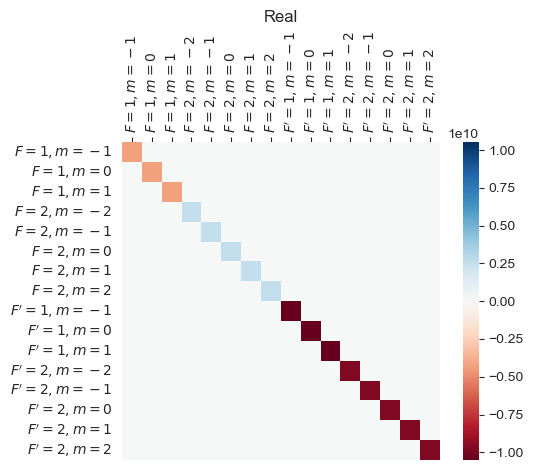

In [68]:
maplot(Ha(+10e9))


100 GHz detuned

(<Figure size 600x480 with 2 Axes>, <AxesSubplot:title={'center':'Real'}>)

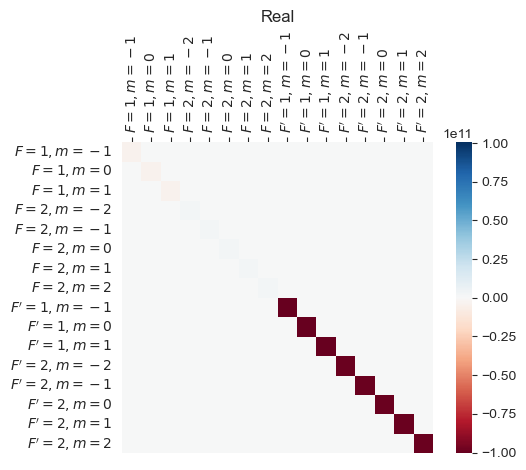

In [66]:
maplot(Ha(+100e9))


(<Figure size 600x480 with 2 Axes>, <AxesSubplot:title={'center':'Real'}>)

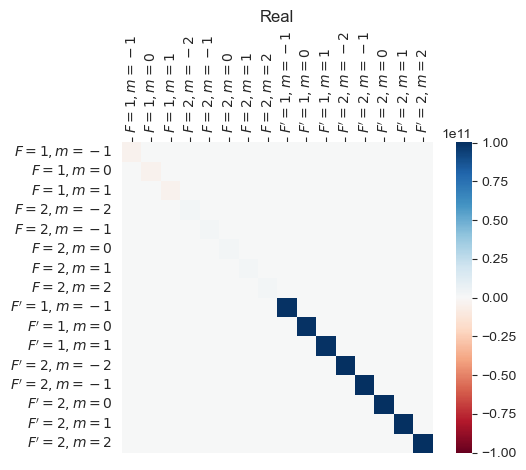

In [67]:
maplot(Ha(-100e9))


(<Figure size 600x480 with 2 Axes>, <AxesSubplot:title={'center':'Real'}>)

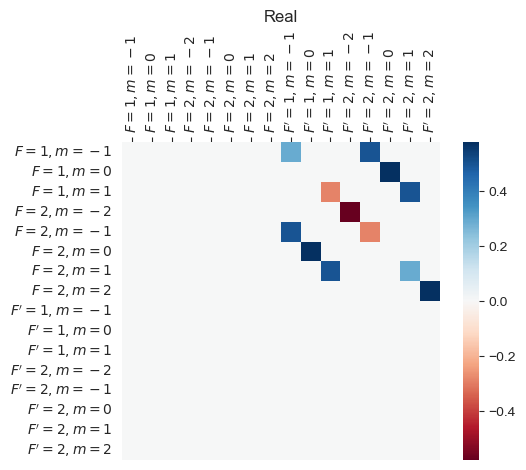

In [17]:
maplot(sigma_q(0))


(<Figure size 600x480 with 2 Axes>, <AxesSubplot:title={'center':'Real'}>)

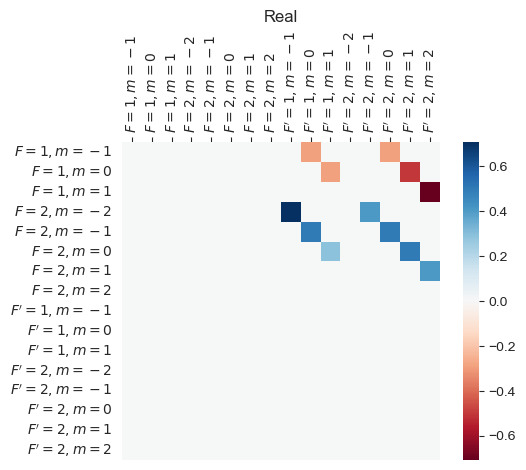

In [18]:
maplot(sigma_q(-1))


(<Figure size 600x480 with 2 Axes>, <AxesSubplot:title={'center':'Real'}>)

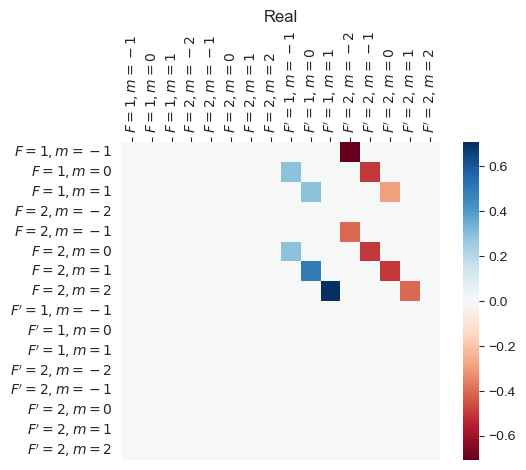

In [19]:
maplot(sigma_q(1))


### Laser Polarization: $\sigma_-$ (since q=1), F=2 -> F'=1

(<Figure size 600x480 with 2 Axes>, <AxesSubplot:title={'center':'Real'}>)

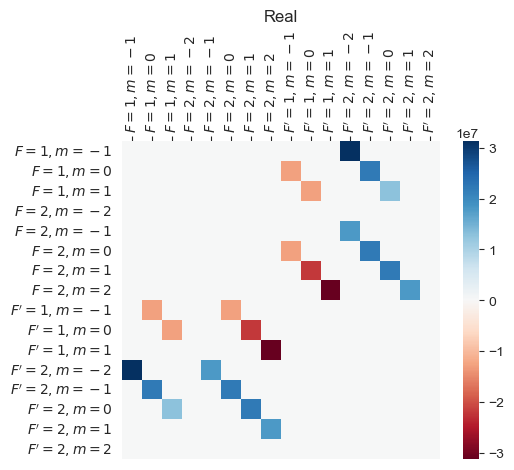

In [20]:
maplot(H_AF(1, laser_intens))


(<Figure size 600x480 with 2 Axes>, <AxesSubplot:title={'center':'Real'}>)

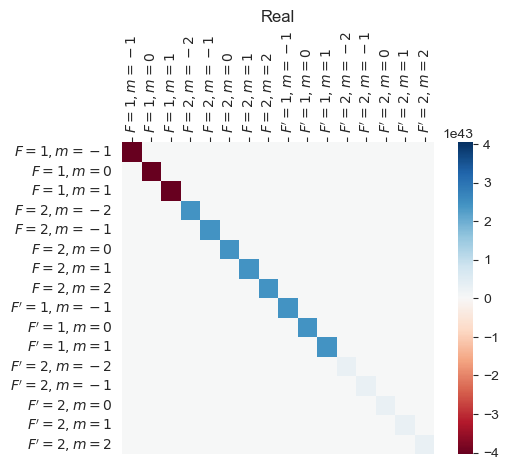

In [21]:
maplot(Ha(-509.06e6 - 2.563005979089109e9))


(<Figure size 600x480 with 2 Axes>, <AxesSubplot:title={'center':'Real'}>)

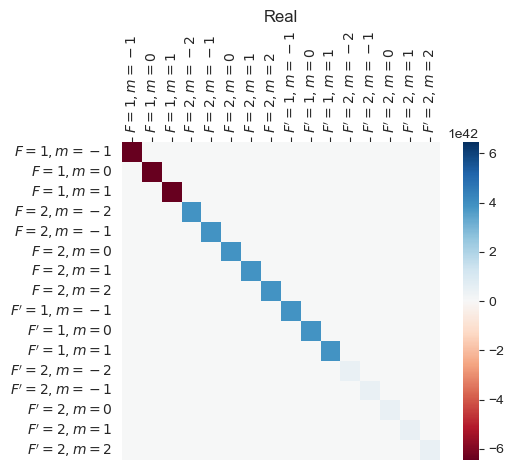

In [22]:
maplot(hamil)


## D1 Driving, No Decay

Starting state: equal population in ground states

In [3]:
starting_state = sum([basis(16, i).proj() for i in range(8)])
starting_state = starting_state.unit()
times = np.linspace(0, 1e-6, 1000)
opts = Options(nsteps=3 * 10**4)
res = mesolve(
    hamil,
    starting_state,
    times,
    options=opts,
)


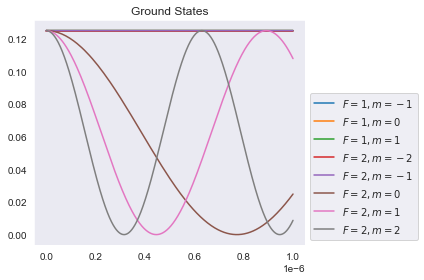

In [4]:
ground_exp = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
plt.figure()
for e in ground_exp:
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
)
plt.title("Ground States")
plt.tight_layout()


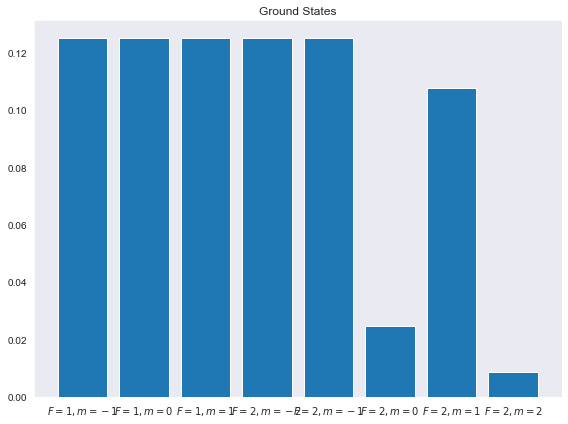

In [5]:
plt.figure(figsize=(8, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8)], [np.real(e)[-1] for e in ground_exp]
)
plt.title("Ground States")
plt.tight_layout()


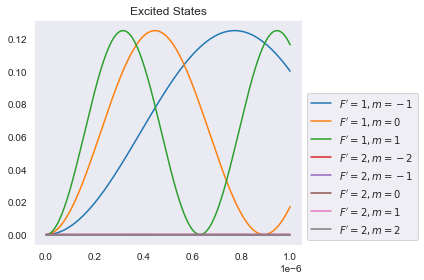

In [6]:
excited_exp = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8, 16)
]
plt.figure()
for e in excited_exp:
    plt.plot(times, np.real(e))
plt.title("Excited States")
plt.legend(
    [index_to_F_mF_string(i) for i in range(8, 16)],
    loc="best",
    bbox_to_anchor=(1.0, 0.7),
)
plt.tight_layout()


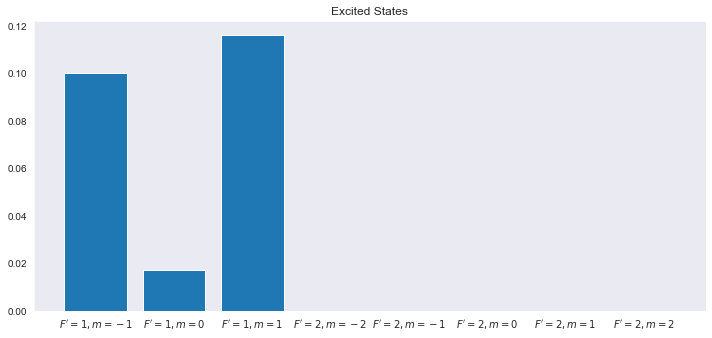

In [7]:
plt.figure(figsize=(10, 4.8))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8, 16)],
    [np.real(e)[-1] for e in excited_exp],
)
plt.title("Excited States")

plt.tight_layout()


# Radiative Decay Only

In [8]:
print(f"""{rabi(off_resonant_saturation_intensity_D1_pi_pol*10):.2e}""")


-2.23e+07


In [9]:
L = sum([lindblad_dissipator(a=c) for c in natural_decay_ops])

In [10]:
import plotly.express as px

y = L.full().real
fig = px.imshow(
    y,
    color_continuous_midpoint=0,
    aspect="equal",
    width=1.5 * 800,
    height=1.5 * 400,
    zmin=-(abs(y).max()),
    zmax=(abs(y).max()),
    color_continuous_scale="RdBu",
)
fig.show()


In [11]:
L.iscptp

False

### $T = 10\, ns$

In [12]:
starting_state = sum([basis(16, i).proj() for i in range(8, 16)])
# starting_state = basis(16, 16).proj()
starting_state = starting_state.unit()


In [13]:
times = np.linspace(0, 1e-6, 1000)
opts = Options(nsteps=1 * 10**3)
res = mesolve(
    L,
    starting_state,
    times,
    options=opts,
)


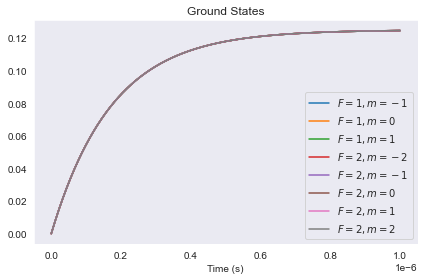

In [14]:
ground_exp = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
plt.figure()
for e in ground_exp:
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
)
plt.title("Ground States")
plt.xlabel("Time (s)")

plt.tight_layout()


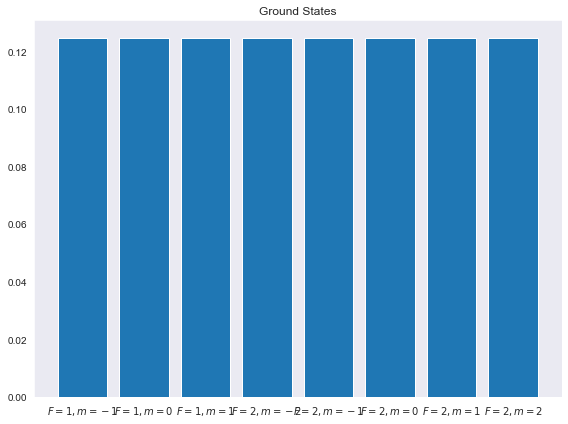

In [15]:
plt.figure(figsize=(8, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8)], [np.real(e)[-1] for e in ground_exp]
)
plt.title("Ground States")
plt.tight_layout()


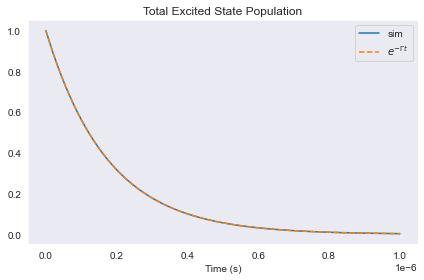

In [16]:
excited_exp = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(8, 16)
        ]
    )
    for t in range(len(times))
]
plt.figure()
# for e in excited_exp:
plt.plot(times, np.real(excited_exp), label="sim")
plt.plot(
    times, [np.exp(-gamma_natural * t) for t in times], "--", label=r"$e^{-\Gamma t}$"
)
plt.legend()
plt.title("Total Excited State Population")
plt.xlabel("Time (s)")
plt.tight_layout()


### Random Excited State Starting Population

In [17]:
starting_state = sum([random.random() * basis(16, i).proj() for i in range(8, 16)])
# starting_state = basis(16, 16).proj()
starting_state = starting_state.unit()


In [18]:
times = np.linspace(0, 1e-6, 1000)
opts = Options(nsteps=1 * 10**3)
res = mesolve(
    L,
    starting_state,
    times,
    options=opts,
)


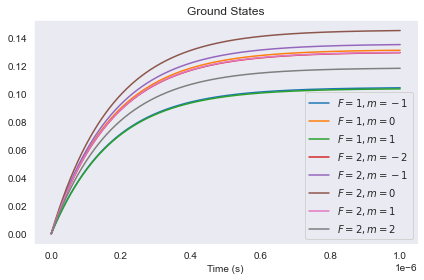

In [19]:
ground_exp = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
plt.figure()
for e in ground_exp:
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
)
plt.title("Ground States")
plt.xlabel("Time (s)")

plt.tight_layout()


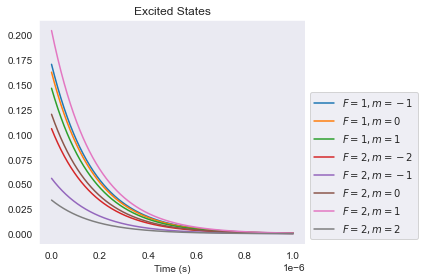

In [20]:
exc_exp = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8, 16)
]
plt.figure()
for e in exc_exp:
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
)
plt.title("Excited States")
plt.xlabel("Time (s)")

plt.tight_layout()


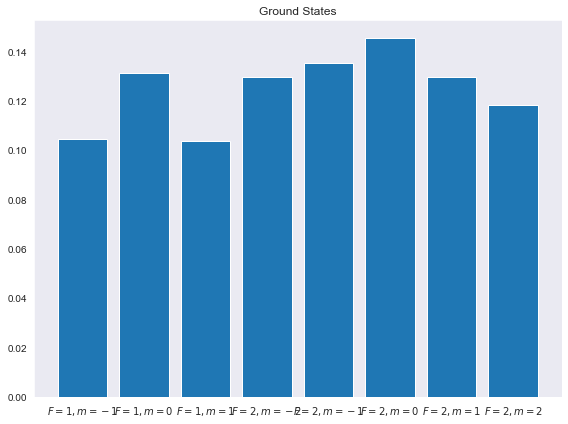

In [21]:
plt.figure(figsize=(8, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8)], [np.real(e)[-1] for e in ground_exp]
)
plt.title("Ground States")
plt.tight_layout()


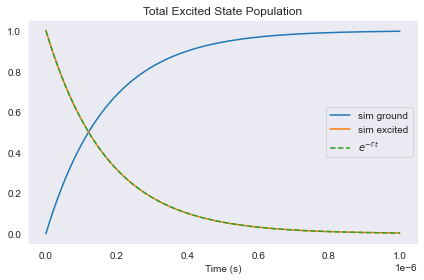

In [22]:
excited_exp = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(8, 16)
        ]
    )
    for t in range(len(times))
]
total_ground_exp = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(8)
        ]
    )
    for t in range(len(times))
]
plt.figure()
plt.plot(times, np.real(total_ground_exp), label="sim ground")
plt.plot(times, np.real(excited_exp), label="sim excited")
plt.plot(
    times, [np.exp(-gamma_natural * t) for t in times], "--", label=r"$e^{-\Gamma t}$"
)
plt.legend()
plt.xlabel("Time (s)")
plt.title("Total Excited State Population")
plt.tight_layout()


# Quenching Only

(<Figure size 600x480 with 2 Axes>, <AxesSubplot:title={'center':'Real'}>)

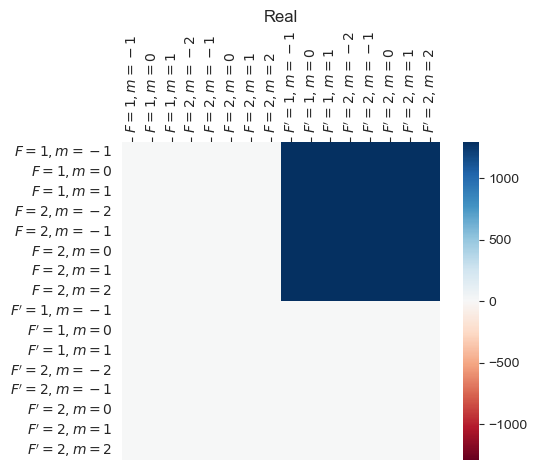

In [23]:
maplot(sum(quenching_ops))


(<Figure size 600x480 with 2 Axes>, <AxesSubplot:title={'center':'Real'}>)

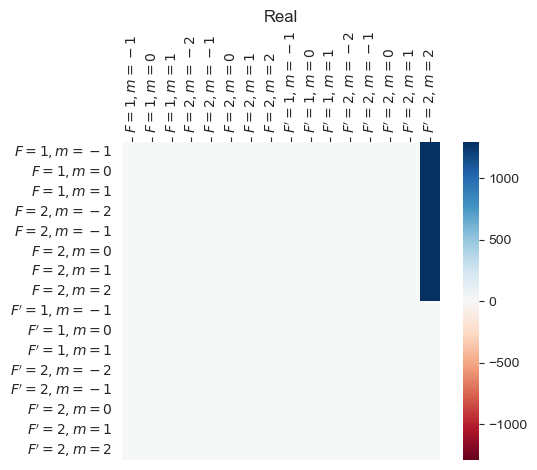

In [24]:
maplot(quenching_ops[-1])


In [26]:
L = liouvillian(None, c_ops=quenching_ops)

## Time Evo

### excited state equally populated

In [27]:
starting_state = sum(
    [basis(16, i).proj() for i in range(8, 16)]
)  # excited state equally populated
starting_state = starting_state.unit()
times = np.linspace(0, 1e-6, 1000)
opts = Options(nsteps=2 * 10**4)
res = mesolve(
    L,
    starting_state,
    times,
    options=opts,
)


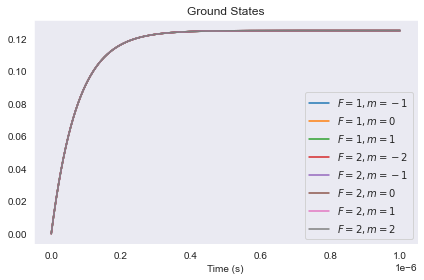

In [28]:
ground_exp = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
plt.figure()
for e in ground_exp:
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
)
plt.title("Ground States")
plt.xlabel("Time (s)")

plt.tight_layout()


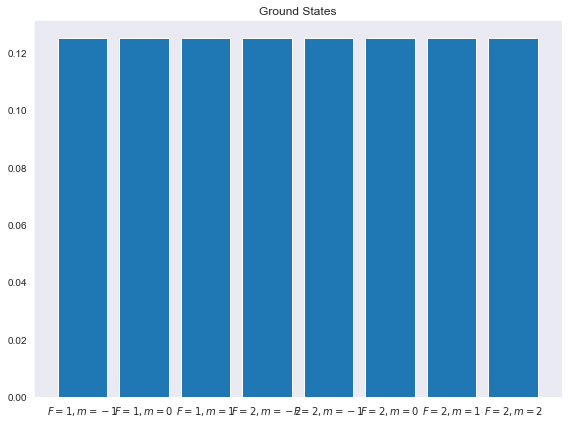

In [29]:
plt.figure(figsize=(8, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8)], [np.real(e)[-1] for e in ground_exp]
)
plt.title("Ground States")
plt.tight_layout()


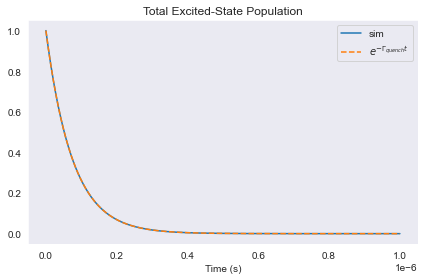

In [30]:
excited_exp = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(8, 16)
        ]
    )
    for t in range(len(times))
]
plt.figure()
# for e in excited_exp:
plt.plot(times, np.real(excited_exp), label="sim")
plt.plot(
    times,
    [np.exp(-quenching_rate * t) for t in times],
    "--",
    label=r"$e^{-\Gamma_{quench} t}$",
)
plt.legend()
plt.title("Total Excited-State Population")
plt.xlabel("Time (s)")
plt.tight_layout()


### $\rho_0 = |F'=2, m'_F=2\rangle$

In [31]:
starting_state = basis(16, 15).proj()
times = np.linspace(0, 1e-6, 1000)
opts = Options(nsteps=2 * 10**4)
res = mesolve(
    L,
    starting_state,
    times,
    options=opts,
)


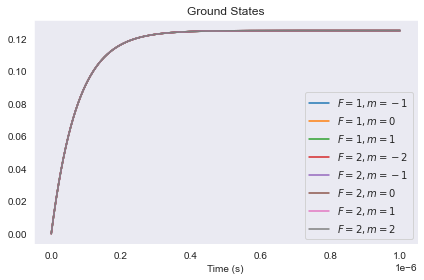

In [32]:
ground_exp = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
plt.figure()
for e in ground_exp:
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
)
plt.title("Ground States")
plt.xlabel("Time (s)")

plt.tight_layout()


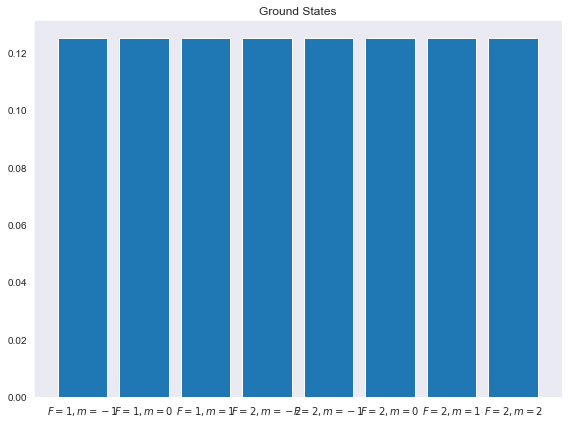

In [33]:
plt.figure(figsize=(8, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8)], [np.real(e)[-1] for e in ground_exp]
)
plt.title("Ground States")
plt.tight_layout()


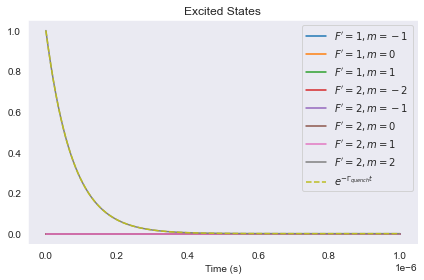

In [34]:
excited_exp = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for i in range(8, 16)
    ]
    for t in range(len(times))
]
plt.figure()
# for e in excited_exp:
plt.plot(
    times, np.real(excited_exp), label=[index_to_F_mF_string(i) for i in range(8, 16)]
)
plt.plot(
    times,
    [np.exp(-quenching_rate * t) for t in times],
    "--",
    label=r"$e^{-\Gamma_{quench} t}$",
)
plt.legend()
plt.title("Excited States")
plt.xlabel("Time (s)")
plt.tight_layout()


# Driven By D1 Laser: $\sigma_-$, $|F=2\rangle \rightarrow |F'=1\rangle$, Damped by Radiative Decay

In [35]:
L = liouvillian(hamil, c_ops=natural_decay_ops)

In [36]:
import plotly.express as px

y = L.full().real
fig = px.imshow(
    y,
    color_continuous_midpoint=0,
    aspect="equal",
    width=1.5 * 800,
    height=1.5 * 400,
    zmin=-(abs(y).max()),
    zmax=(abs(y).max()),
    color_continuous_scale="RdBu",
)
fig.show()


In [37]:
L.istp

False

In [38]:
L.iscp

False

### Time Evolution

#### $T = 10\, \mu s$

In [39]:
starting_state = sum(
    [basis(16, i).proj() for i in range(8)]
)  # ground states equally populated
starting_state = starting_state.unit()


In [40]:
times = np.linspace(0, 1e-6, 1000)
opts = Options(nsteps=2 * 10**4)
res = mesolve(
    L,
    starting_state,
    times,
    options=opts,
)


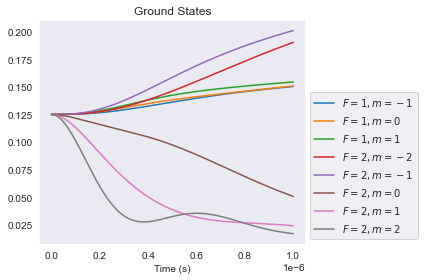

In [41]:
ground_exp = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
plt.figure()
for e in ground_exp:
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
)
plt.title("Ground States")
plt.xlabel("Time (s)")

plt.tight_layout()


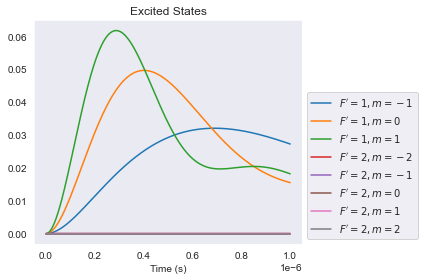

In [42]:
exc_states = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8, 16)
]
plt.figure()
for e in exc_states:
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8, 16)],
    loc="best",
    bbox_to_anchor=(1.0, 0.7),
)
plt.title("Excited States")
plt.xlabel("Time (s)")

plt.tight_layout()


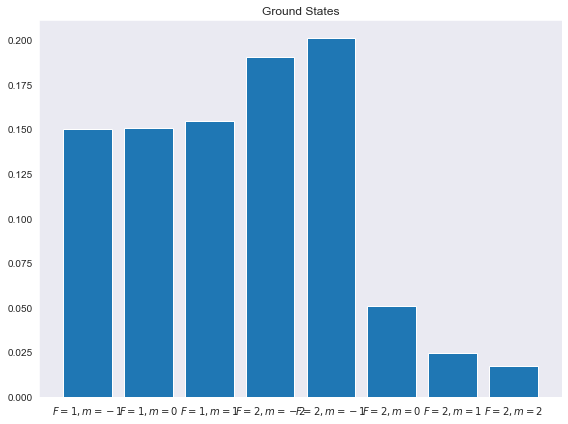

In [43]:
plt.figure(figsize=(8, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8)], [np.real(e)[-1] for e in ground_exp]
)
plt.title("Ground States")
plt.tight_layout()


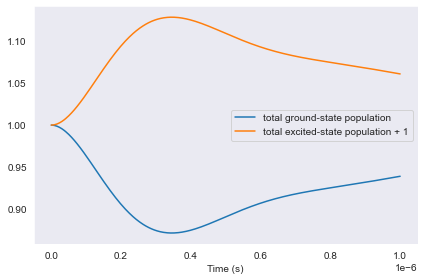

In [44]:
tot_excited_exp = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(8, 16)
        ]
    )
    + 1
    for t in range(len(times))
]
tot_g_exp = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(8)
        ]
    )
    for t in range(len(times))
]
plt.figure()
plt.plot(times, np.real(tot_g_exp), label="total ground-state population")
plt.plot(times, np.real(tot_excited_exp), label="total excited-state population + 1")
plt.legend()
plt.xlabel("Time (s)")
plt.tight_layout()


#### $T = 10\, ms$

In [45]:
starting_state = sum(
    [basis(16, i).proj() for i in range(8)]
)  # ground states equally populated
starting_state = starting_state.unit()


In [46]:
times = np.linspace(0, 1e-4, 1000)
opts = Options(nsteps=2 * 10**4)
res = mesolve(
    L,
    starting_state,
    times,
    options=opts,
)


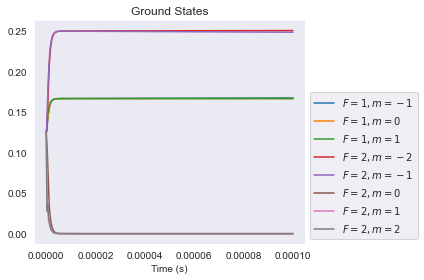

In [47]:
ground_exp = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
plt.figure()
for e in ground_exp:
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
)
plt.title("Ground States")
plt.xlabel("Time (s)")

plt.tight_layout()


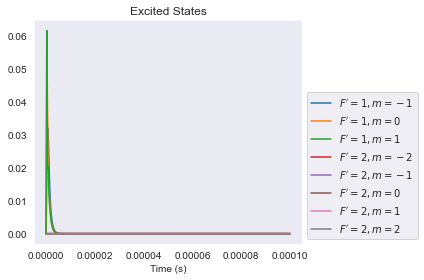

In [48]:
exc_states = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8, 16)
]
plt.figure()
for e in exc_states:
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8, 16)],
    loc="best",
    bbox_to_anchor=(1.0, 0.7),
)
plt.title("Excited States")
plt.xlabel("Time (s)")

plt.tight_layout()


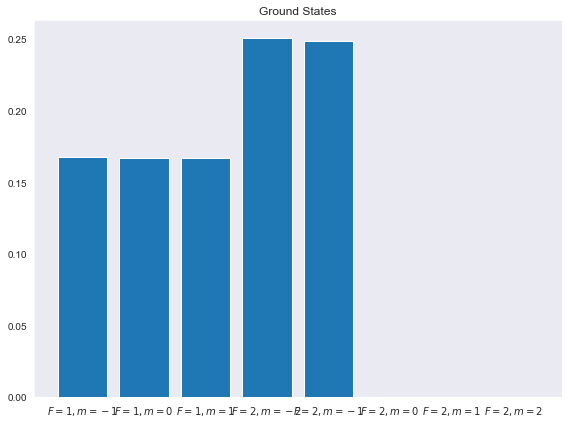

In [49]:
plt.figure(figsize=(8, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8)], [np.real(e)[-1] for e in ground_exp]
)
plt.title("Ground States")
plt.tight_layout()


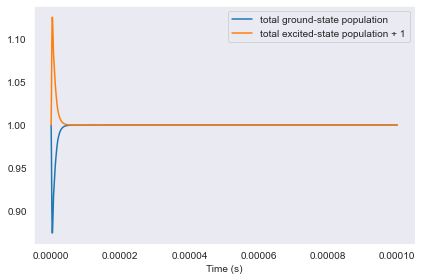

In [50]:
tot_excited_exp = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(8, 16)
        ]
    )
    + 1
    for t in range(len(times))
]
tot_g_exp = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(8)
        ]
    )
    for t in range(len(times))
]
plt.figure()
plt.plot(times, np.real(tot_g_exp), label="total ground-state population")
plt.plot(times, np.real(tot_excited_exp), label="total excited-state population + 1")
plt.legend()
plt.xlabel("Time (s)")
plt.tight_layout()


### Steady State

#### Lindblad Superoperator

Matrix representation of operators are transformed to vectors by column-stacking.

In [51]:
operator_to_vector(basis(2, 0) * basis(2, 1).dag())


Quantum object: dims = [[[2], [2]], [1]], shape = (4, 1), type = operator-ket
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]]

In [52]:
operator_to_vector(hamil)


Quantum object: dims = [[[16], [16]], [1]], shape = (256, 1), type = operator-ket
Qobj data =
[[-4.27167663e+09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 4.97973926e+06]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-4.27167663e+09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.03297004e+06]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 3.52120740e+06]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-4.27167663e+09]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.03297004e+06]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 2.03297004e+06]
 [ 0.00000000e+00]
 [ 0.00000000

(<Figure size 1680x672 with 4 Axes>,
 [<AxesSubplot:title={'center':'Real'}>,
  <AxesSubplot:title={'center':'Imag'}>])

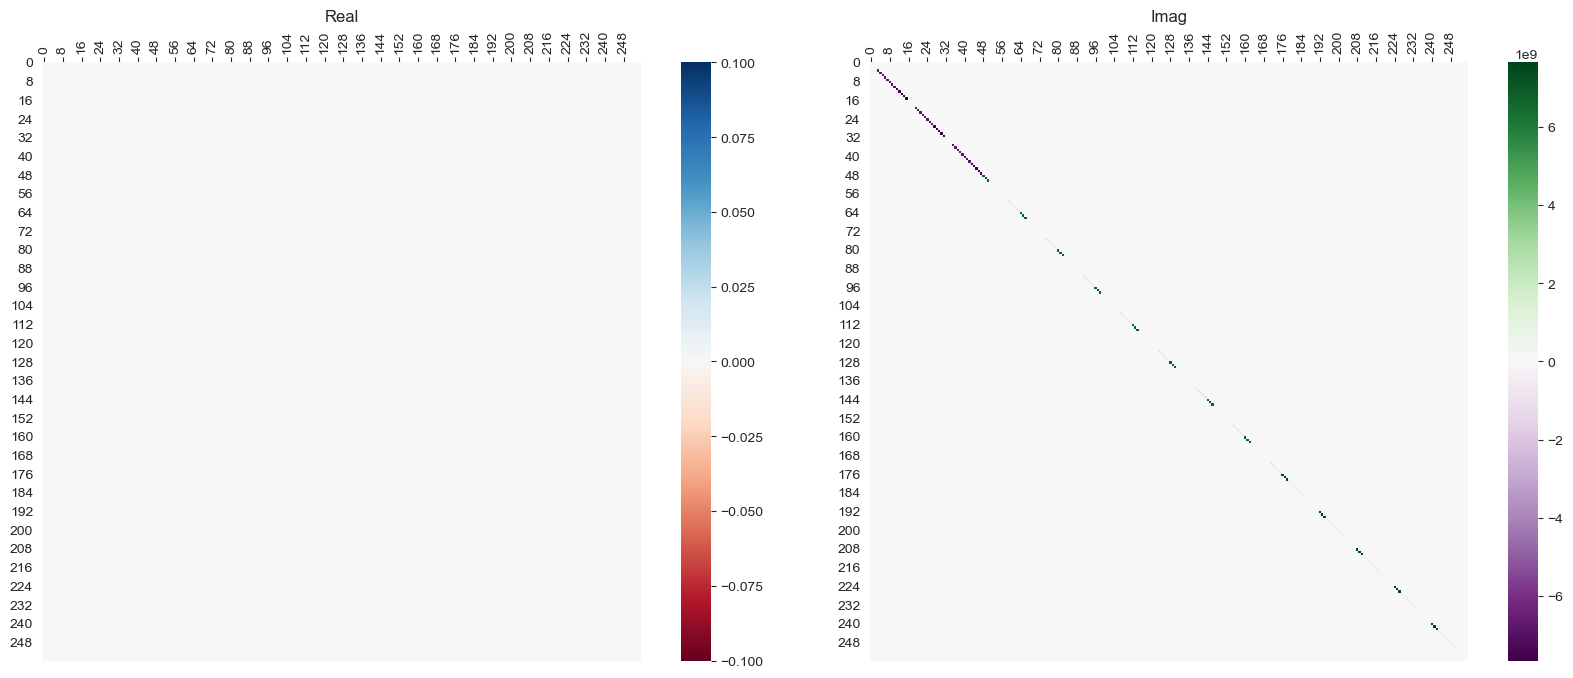

In [53]:
matrixplot(liouvillian(hamil))


(<Figure size 600x480 with 2 Axes>, <AxesSubplot:title={'center':'Real'}>)

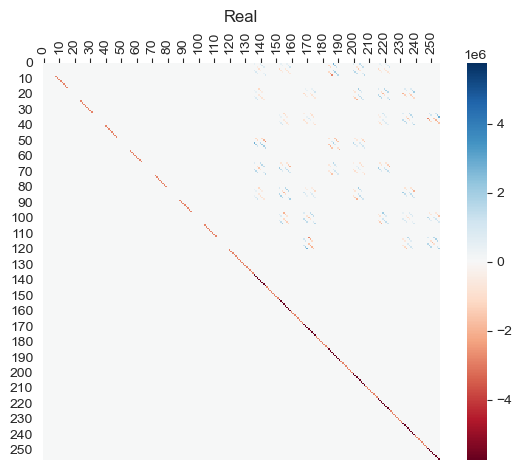

In [54]:
matrixplot(liouvillian(hamil * 0, c_ops=natural_decay_ops))


In [55]:
L = liouvillian(hamil, c_ops=natural_decay_ops)


(<Figure size 1680x672 with 4 Axes>,
 [<AxesSubplot:title={'center':'Real'}>,
  <AxesSubplot:title={'center':'Imag'}>])

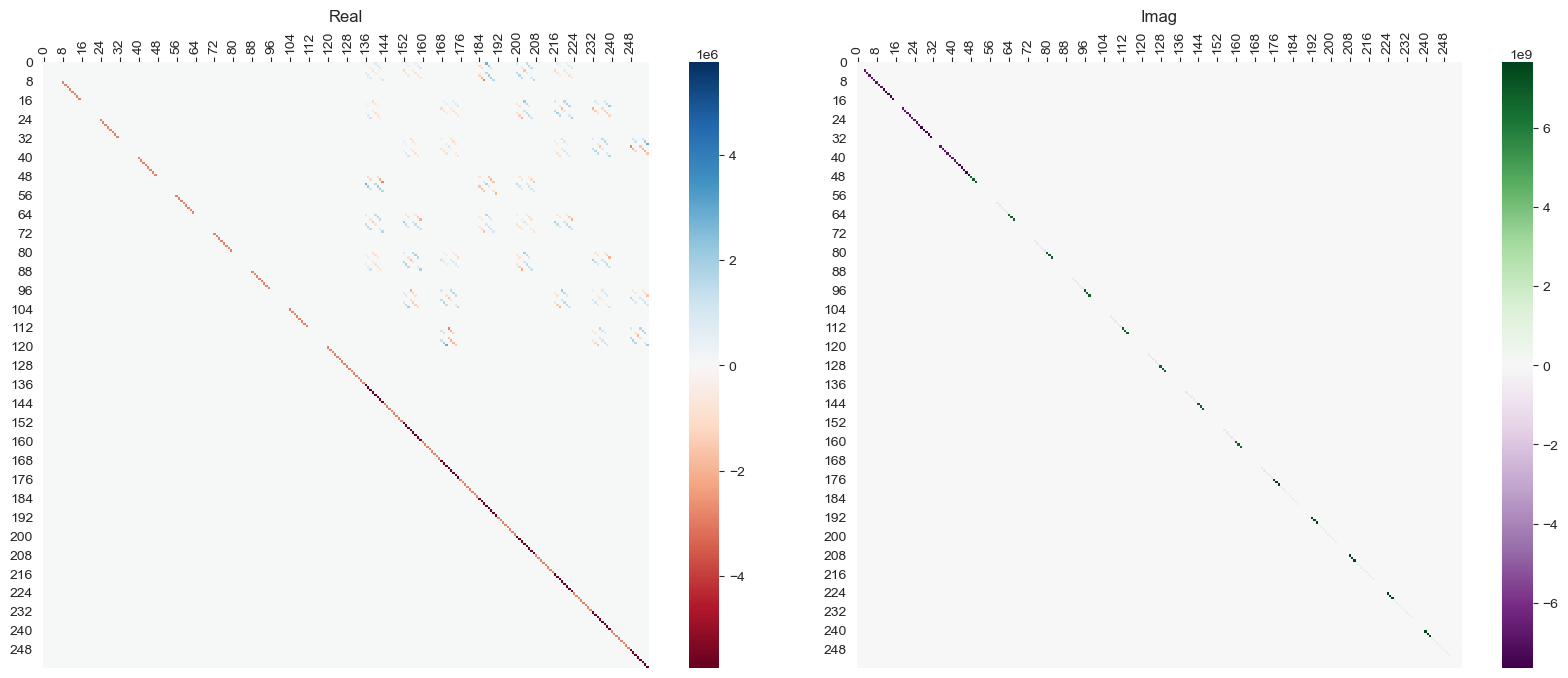

In [56]:
matrixplot(L)


In [57]:
rho_dot_zero = vector_to_operator(L * operator_to_vector(starting_state))


(<Figure size 1680x672 with 4 Axes>,
 [<AxesSubplot:title={'center':'Real'}>,
  <AxesSubplot:title={'center':'Imag'}>])

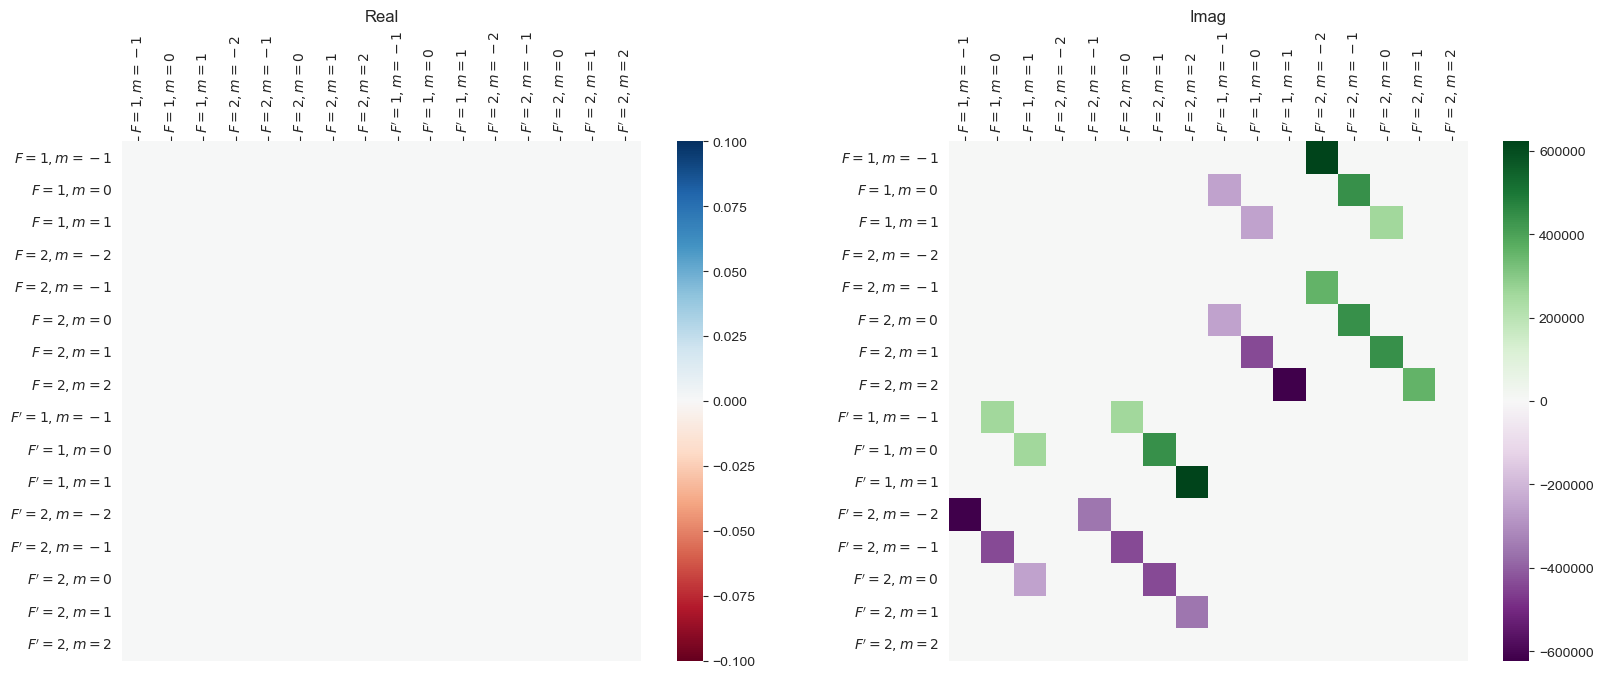

In [58]:
maplot(rho_dot_zero)


In [59]:
rho_dot_zero = vector_to_operator(L * operator_to_vector(basis(16, 0).proj()))


(<Figure size 1680x672 with 4 Axes>,
 [<AxesSubplot:title={'center':'Real'}>,
  <AxesSubplot:title={'center':'Imag'}>])

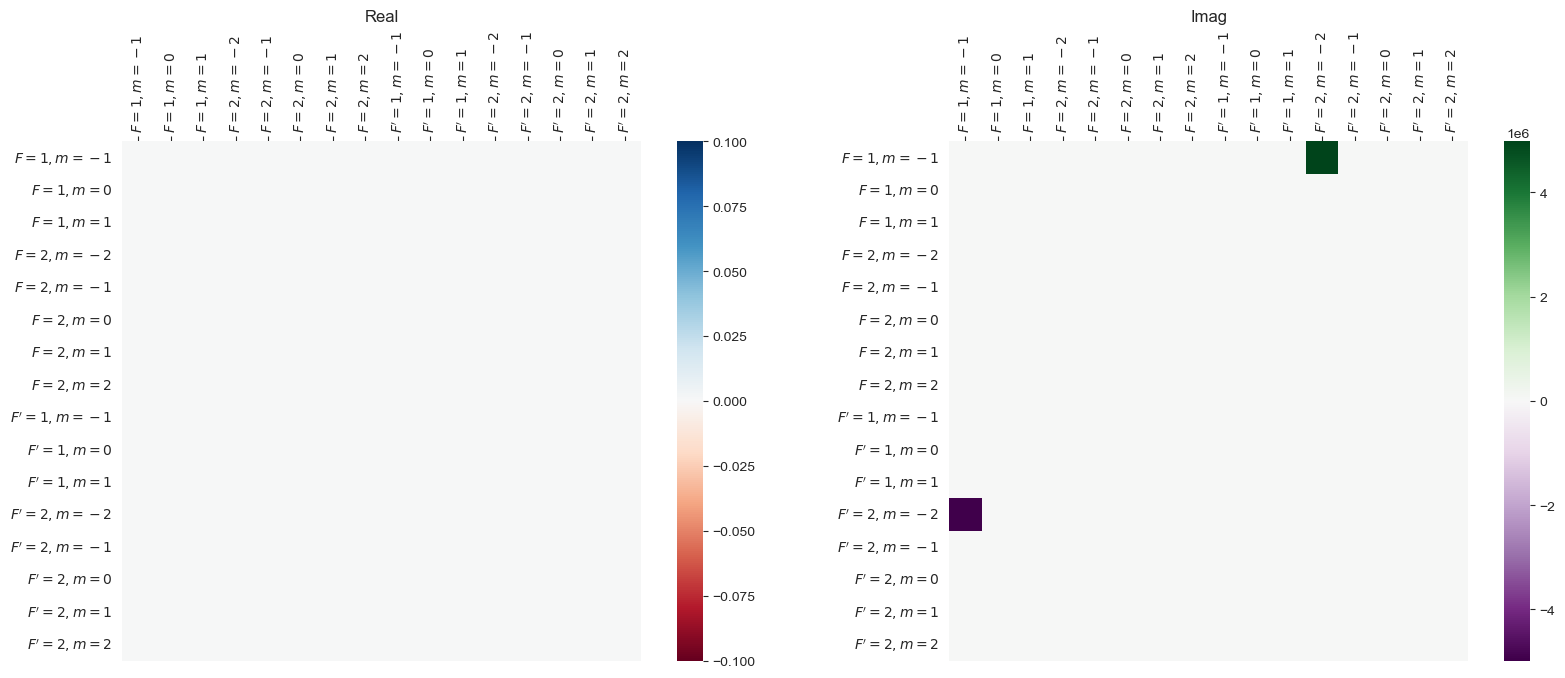

In [60]:
maplot(rho_dot_zero)


In [61]:
rho_dot_zero = vector_to_operator(L * operator_to_vector(basis(16, 15).proj()))


(<Figure size 600x480 with 2 Axes>, <AxesSubplot:title={'center':'Real'}>)

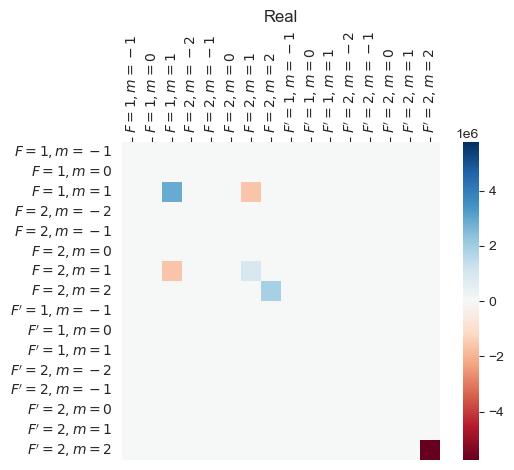

In [62]:
maplot(rho_dot_zero)


In [63]:
rho_dot_zero = vector_to_operator(L * operator_to_vector(basis(16, 14).proj()))


(<Figure size 1680x672 with 4 Axes>,
 [<AxesSubplot:title={'center':'Real'}>,
  <AxesSubplot:title={'center':'Imag'}>])

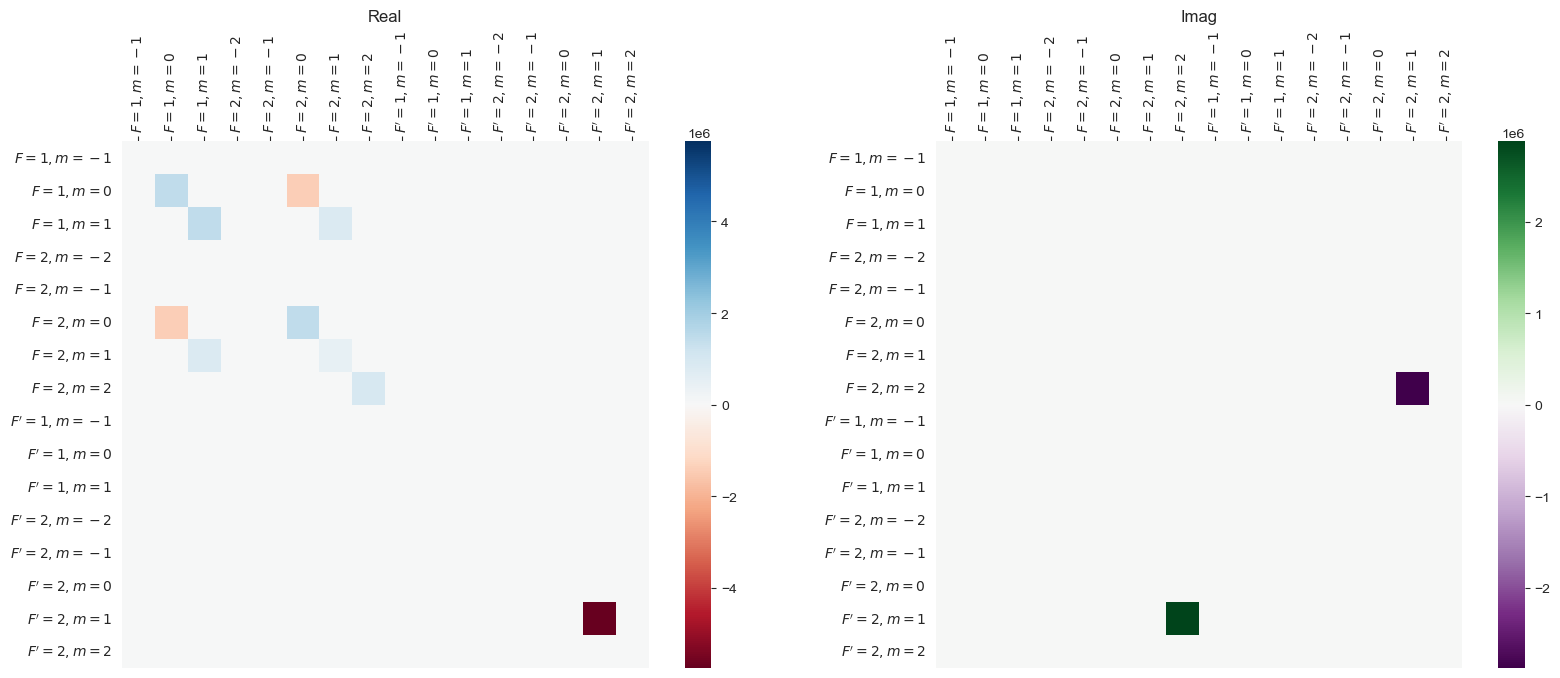

In [64]:
maplot(rho_dot_zero)


##### A Steady State for $\sigma_-$ pump is the dark state $|F=2, m_F=-2 \rangle$

In [65]:
lenergy, lstates = L.eigenstates()
np.abs(lenergy).min()


0.0

In [66]:
rho_ss_zero_eigenval = vector_to_operator(lstates[np.abs(lenergy).argmin()])


(<Figure size 600x480 with 2 Axes>, <AxesSubplot:title={'center':'Real'}>)

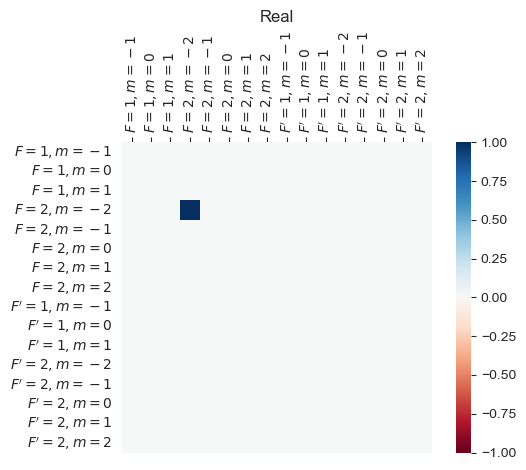

In [67]:
maplot(rho_ss_zero_eigenval)


In [68]:
rho_ss_dot = L * operator_to_vector(rho_ss_zero_eigenval)


(<Figure size 600x480 with 2 Axes>, <AxesSubplot:title={'center':'Real'}>)

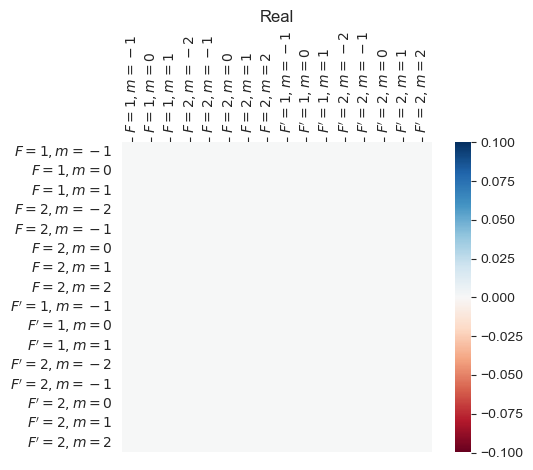

In [69]:
maplot(vector_to_operator(rho_ss_dot))


Test this $\rho_{ss}$ by time evolution

In [70]:
starting_state = basis(16, 3).proj()  # dark
starting_state = starting_state.unit()


In [71]:
times = np.linspace(0, 1e-6, 1000)
opts = Options(nsteps=2 * 10**4)
res = mesolve(
    hamil,
    starting_state,
    times,
    c_ops=natural_decay_ops,
    options=opts,
)


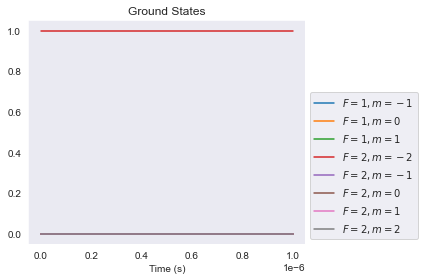

In [72]:
ground_exp = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
plt.figure()
for e in ground_exp:
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
)
plt.title("Ground States")
plt.xlabel("Time (s)")

plt.tight_layout()


#### Different Steady-State Solvers



In [73]:
rho_ss_direct = steadystate(hamil, c_op_list=natural_decay_ops, method="direct")


(<Figure size 600x480 with 2 Axes>, <AxesSubplot:title={'center':'Real'}>)

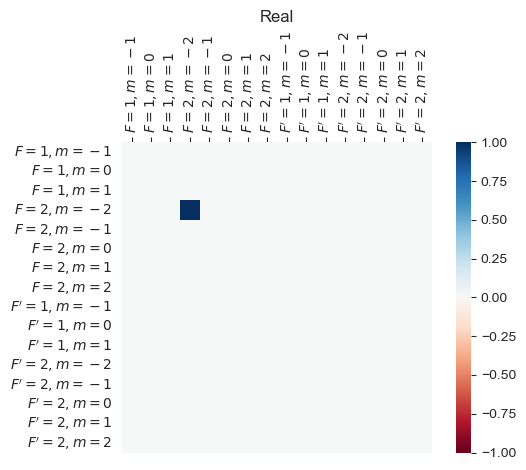

In [74]:
maplot(rho_ss_direct)


In [75]:
rho_ss_power = steadystate(hamil, c_op_list=natural_decay_ops, method="power")


(<Figure size 1680x672 with 4 Axes>,
 [<AxesSubplot:title={'center':'Real'}>,
  <AxesSubplot:title={'center':'Imag'}>])

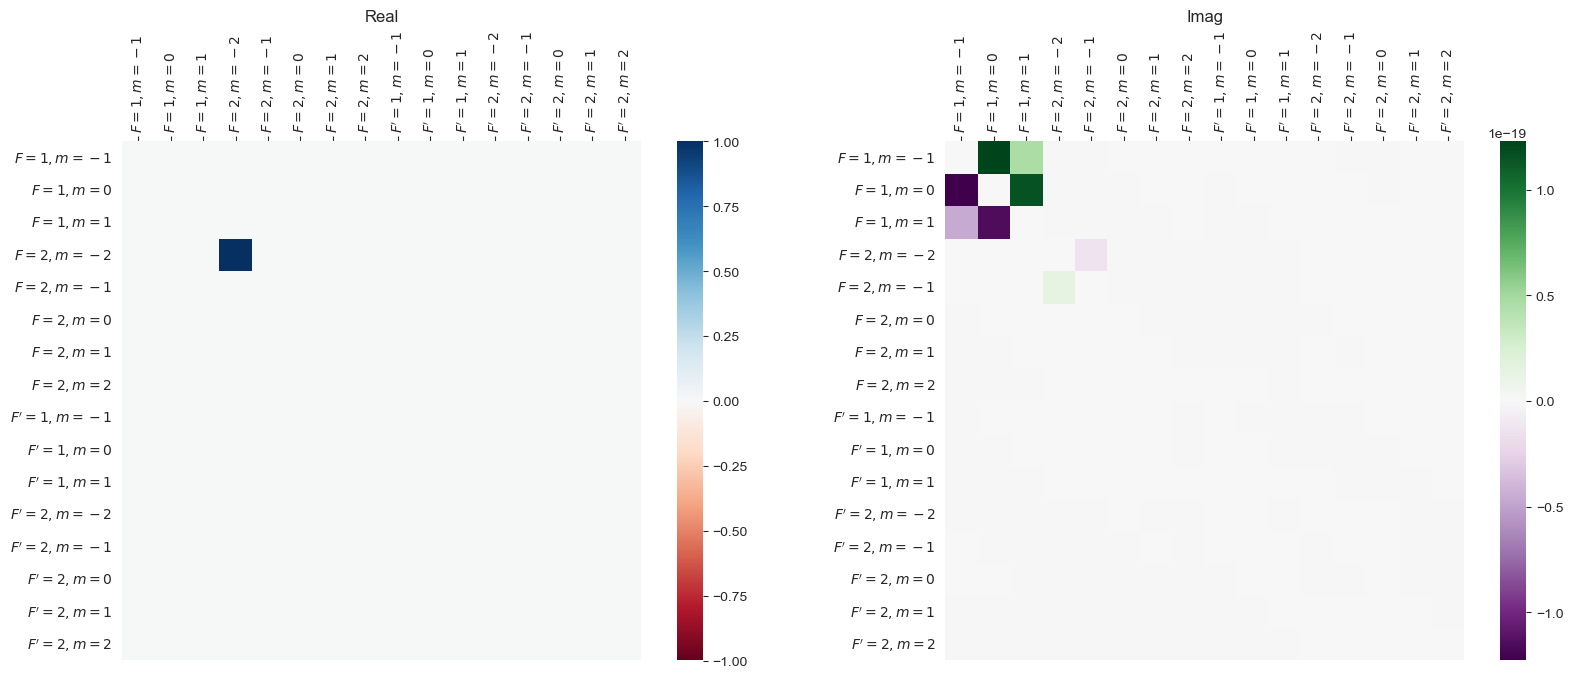

In [76]:
maplot(rho_ss_power)


In [77]:
rho_ss_power.tr()


1.0

In [78]:
rho_ss_it_gmres = steadystate(
    hamil, c_op_list=natural_decay_ops, method="iterative-gmres"
)


(<Figure size 1680x672 with 4 Axes>,
 [<AxesSubplot:title={'center':'Real'}>,
  <AxesSubplot:title={'center':'Imag'}>])

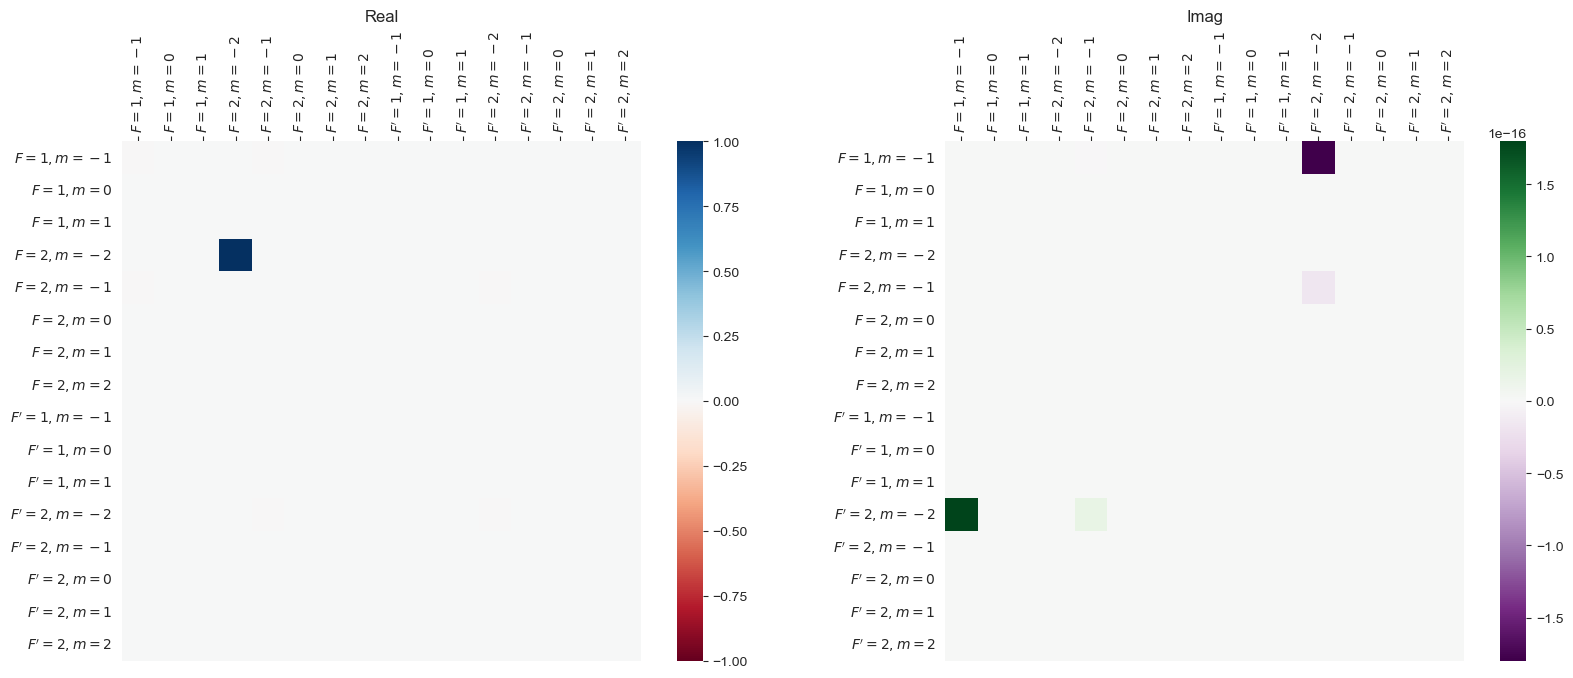

In [79]:
maplot(rho_ss_it_gmres)


In [80]:
rho_ss_it_lgmres = steadystate(
    hamil, c_op_list=natural_decay_ops, method="iterative-lgmres"
)


(<Figure size 1680x672 with 4 Axes>,
 [<AxesSubplot:title={'center':'Real'}>,
  <AxesSubplot:title={'center':'Imag'}>])

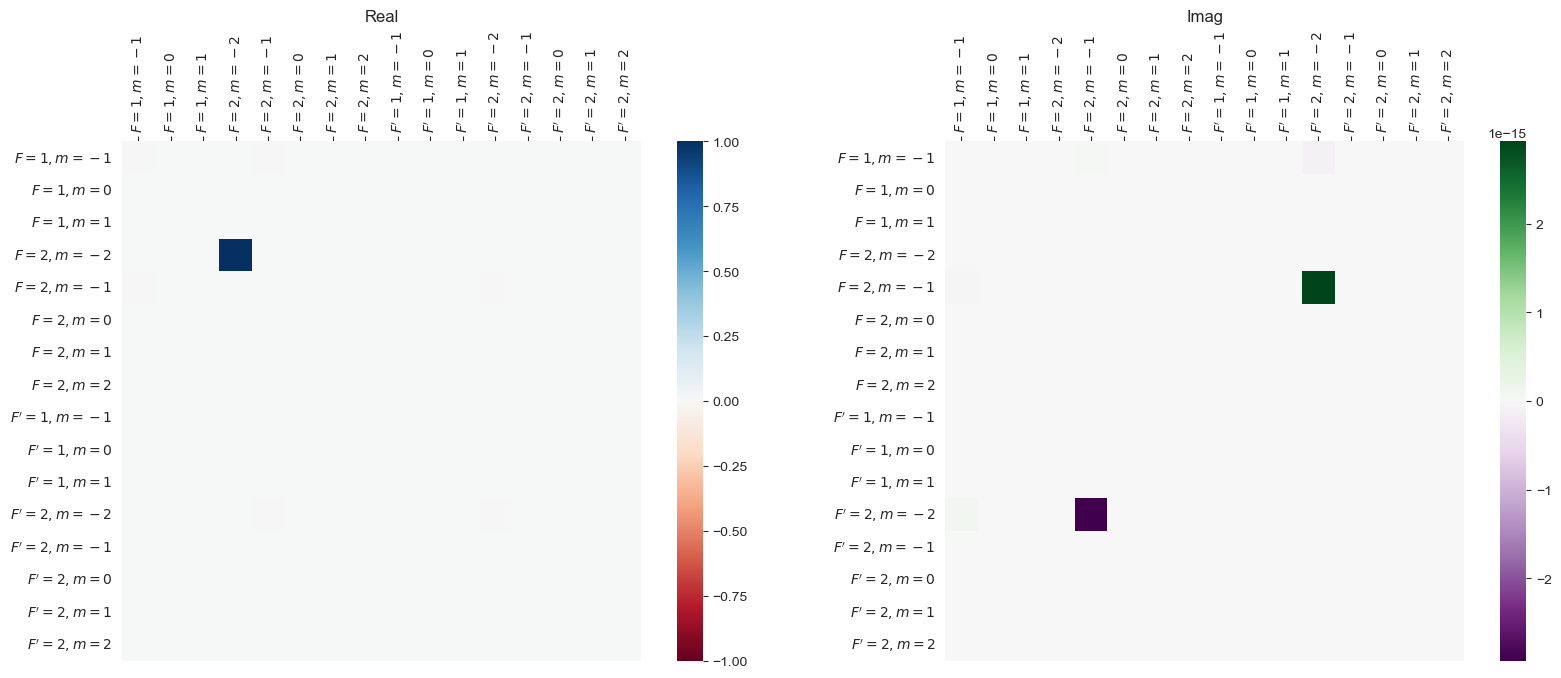

In [81]:
maplot(rho_ss_it_lgmres)


In [82]:
rho_ss_it_bicgstab = steadystate(
    hamil, c_op_list=natural_decay_ops, method="iterative-bicgstab"
)


Exception: Steadystate error: Did not reach tolerance after 1000 steps.
Residual norm: None

In [83]:
maplot(rho_ss_it_bicgstab)


NameError: name 'rho_ss_it_bicgstab' is not defined

In [84]:
rho_ss_svd = steadystate(hamil, c_op_list=natural_decay_ops, method="svd")


(<Figure size 1680x672 with 4 Axes>,
 [<AxesSubplot:title={'center':'Real'}>,
  <AxesSubplot:title={'center':'Imag'}>])

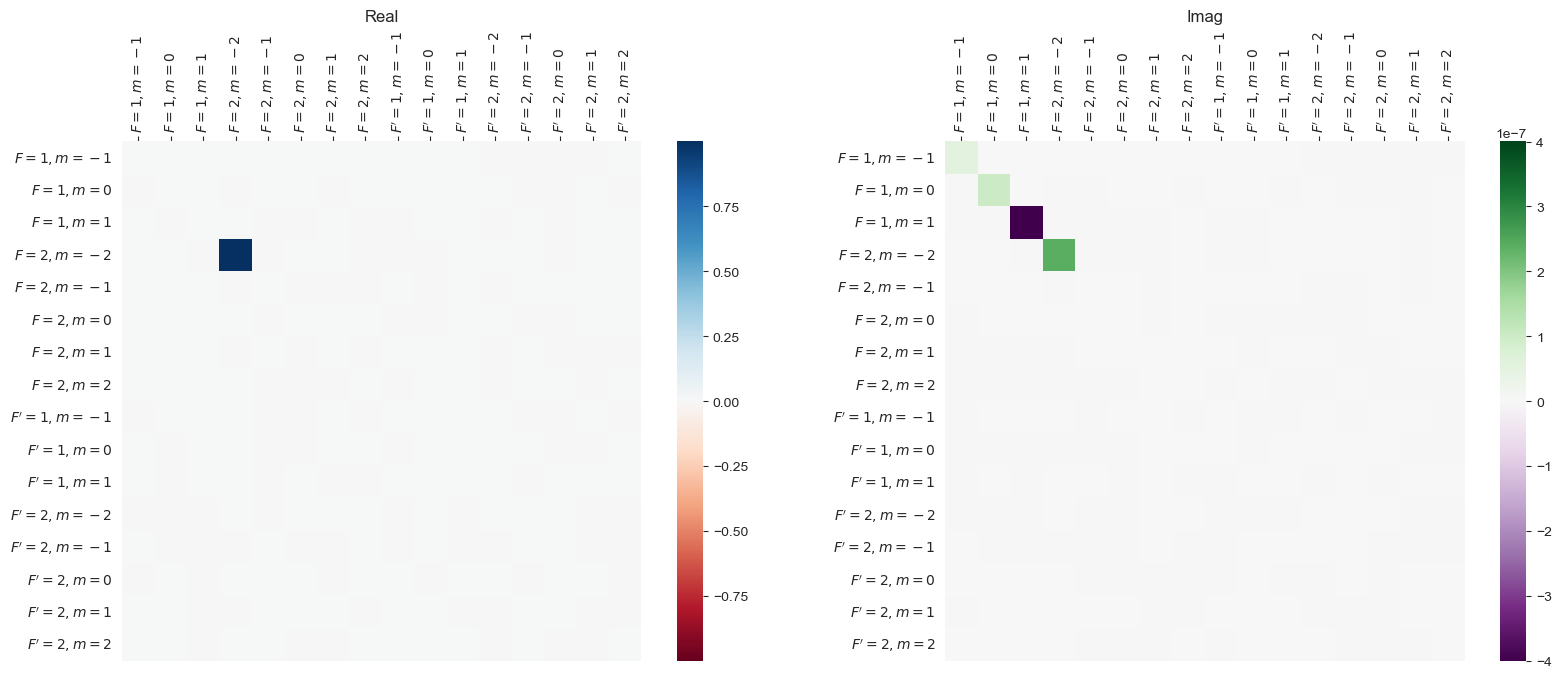

In [85]:
maplot(rho_ss_svd)


In [86]:
rho_ss_svd.tr()


(1-3.539082494550373e-17j)

## Far-Detuned, $\pi$ pol

(<Figure size 600x480 with 2 Axes>, <AxesSubplot:title={'center':'Real'}>)

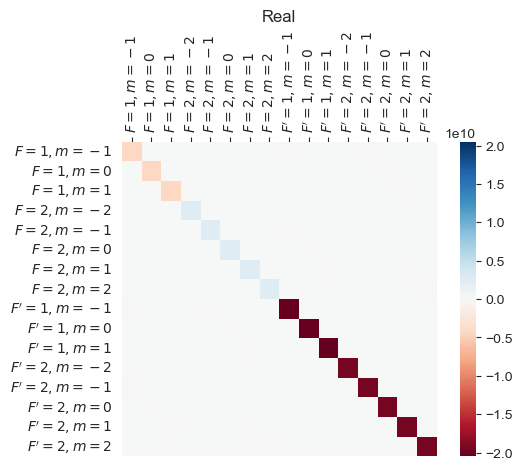

In [87]:
hamil_far_detuned = H_AF(0, laser_intens) + Ha(
    20e9
)  # sigma MINUS (since q=1), F=2 -> F'=1
maplot(hamil_far_detuned)


In [88]:
starting_state = sum([basis(16, i).proj() for i in range(8)])
starting_state = starting_state.unit()


In [89]:
times = np.linspace(0, 1e-6, 1000)
opts = Options(nsteps=1 * 10**3)
res = mesolve(
    hamil_far_detuned,
    starting_state,
    times,
    c_ops=natural_decay_ops,
    options=opts,
)


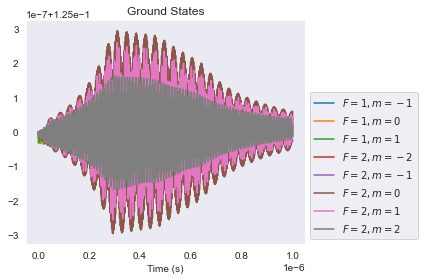

In [90]:
ground_exp = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
plt.figure()
for e in ground_exp:
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
)
plt.title("Ground States")
plt.xlabel("Time (s)")

plt.tight_layout()


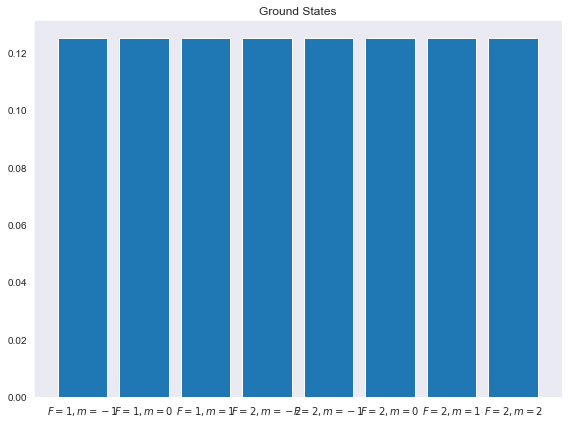

In [91]:
plt.figure(figsize=(8, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8)], [np.real(e)[-1] for e in ground_exp]
)
plt.title("Ground States")
plt.tight_layout()


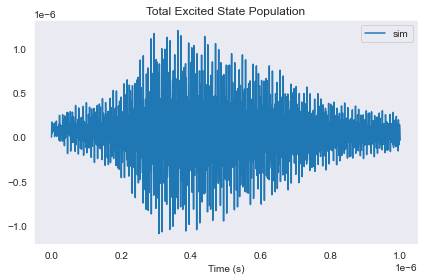

In [92]:
excited_exp = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(8, 16)
        ]
    )
    for t in range(len(times))
]
plt.figure()
# for e in excited_exp:
plt.plot(times, np.real(excited_exp), label="sim")

plt.legend()
plt.title("Total Excited State Population")
plt.xlabel("Time (s)")
plt.tight_layout()


# Ground State Relaxation $\gamma_1$ wrong

In [93]:
gamma_1 = 4.5e3
gamma_1_ops = [
    (gamma_1 / 3) ** (1 / 2) * basis(16, m1) * basis(16, m2 + 3).dag()
    for m1 in range(3)
    for m2 in range(5)
]


(<Figure size 600x480 with 2 Axes>, <AxesSubplot:title={'center':'Real'}>)

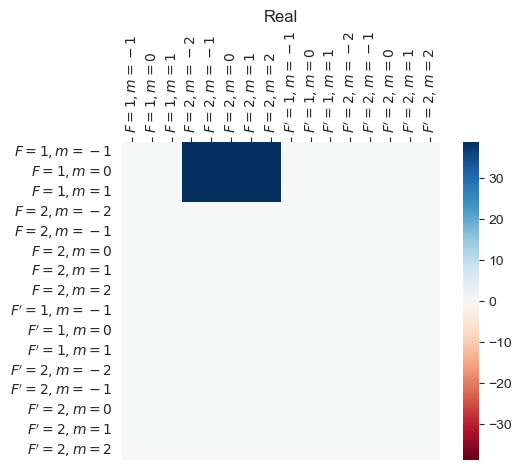

In [94]:
maplot(sum(gamma_1_ops))


In [95]:
starting_state = sum([basis(16, i + 3).proj() for i in range(5)])
# starting_state = basis(16, 16).proj()
starting_state = starting_state.unit()


In [96]:
times = np.linspace(0, 1e-3, 1000)
opts = Options(nsteps=1 * 10**3)
res = mesolve(
    hamil * 0,
    starting_state,
    times,
    c_ops=gamma_1_ops,
    options=opts,
)


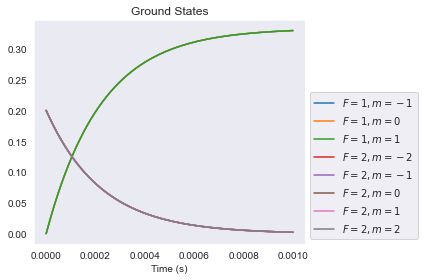

In [97]:
ground_exp = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
plt.figure()
for e in ground_exp:
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
)
plt.title("Ground States")
plt.xlabel("Time (s)")

plt.tight_layout()


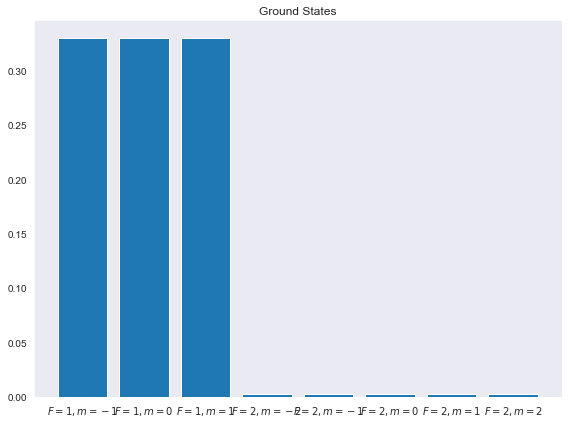

In [98]:
plt.figure(figsize=(8, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8)], [np.real(e)[-1] for e in ground_exp]
)
plt.title("Ground States")
plt.tight_layout()


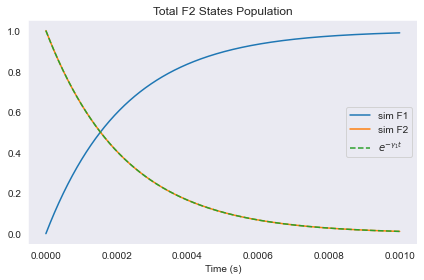

In [99]:
excited_exp = [  # = F2 states
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(3, 8)
        ]
    )
    for t in range(len(times))
]
total_ground_exp = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(3)
        ]
    )
    for t in range(len(times))
]
plt.figure()
plt.plot(times, np.real(total_ground_exp), label="sim F1")
plt.plot(times, np.real(excited_exp), label="sim F2")
plt.plot(times, [np.exp(-gamma_1 * t) for t in times], "--", label=r"$e^{-\gamma_1 t}$")
plt.legend()
plt.xlabel("Time (s)")
plt.title("Total F2 States Population")
plt.tight_layout()


##### Different Starting State

In [100]:
starting_state = sum([basis(16, i).proj() for i in range(7)])
starting_state += 1.5 * basis(16, 7).proj()
# starting_state = basis(16, 16).proj()
starting_state = starting_state.unit()


In [101]:
times = np.linspace(0, 1e-3, 1000)
opts = Options(nsteps=1 * 10**3)
res = mesolve(
    hamil * 0,
    starting_state,
    times,
    c_ops=gamma_1_ops,
    options=opts,
)


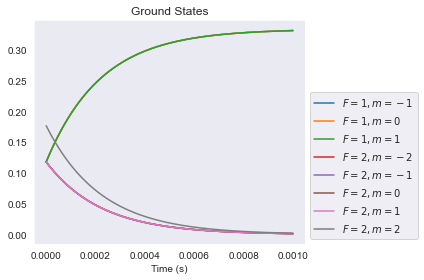

In [102]:
ground_exp = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
plt.figure()
for e in ground_exp:
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
)
plt.title("Ground States")
plt.xlabel("Time (s)")

plt.tight_layout()


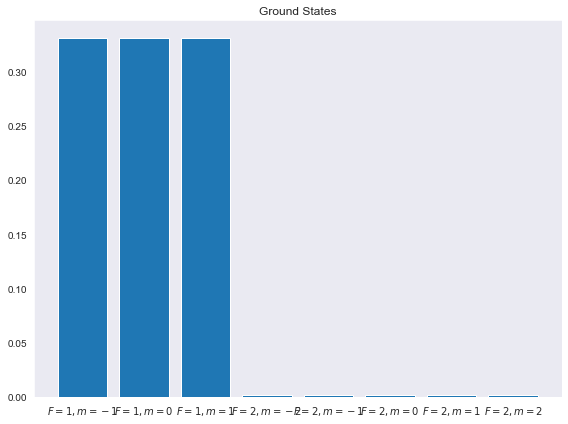

In [103]:
plt.figure(figsize=(8, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8)], [np.real(e)[-1] for e in ground_exp]
)
plt.title("Ground States")
plt.tight_layout()


In [104]:
(starting_state * Fg2_projector()).tr()


0.6470588235294117

In [105]:
(starting_state * Fg1_projector()).tr()


0.3529411764705882

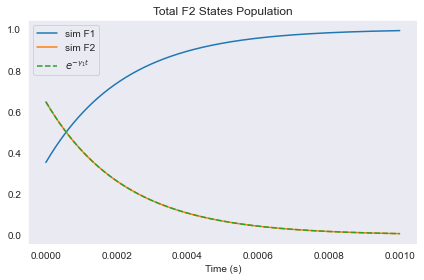

In [106]:
excited_exp = [  #  = F2 states
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(3, 8)
        ]
    )
    for t in range(len(times))
]
total_ground_exp = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(3)
        ]
    )
    for t in range(len(times))
]
plt.figure()
plt.plot(times, np.real(total_ground_exp), label="sim F1")
plt.plot(times, np.real(excited_exp), label="sim F2")
plt.plot(
    times,
    [np.exp(-gamma_1 * t) * (starting_state * Fg2_projector()).tr() for t in times],
    "--",
    label=r"$e^{-\gamma_1 t}$",
)
plt.legend()
plt.xlabel("Time (s)")
plt.title("Total F2 States Population")
plt.tight_layout()


## Ground State Relaxation $\gamma_2$ ?? wrong

In [107]:
gamma_2 = 4.2e3
gamma_2_ops = [
    (gamma_2 / 3) ** (1 / 2) * basis(16, m1) * basis(16, m2).dag()
    for m1 in range(3)
    for m2 in range(3)
    if m1 != m2
]
gamma_2_ops += [
    (gamma_2 / 5) ** (1 / 2) * basis(16, m1) * basis(16, m2).dag()
    for m1 in range(3, 8)
    for m2 in range(3, 8)
    if m1 != m2
]
gamma_2_ops = sum(gamma_2_ops)


(<Figure size 600x480 with 2 Axes>, <AxesSubplot:title={'center':'Real'}>)

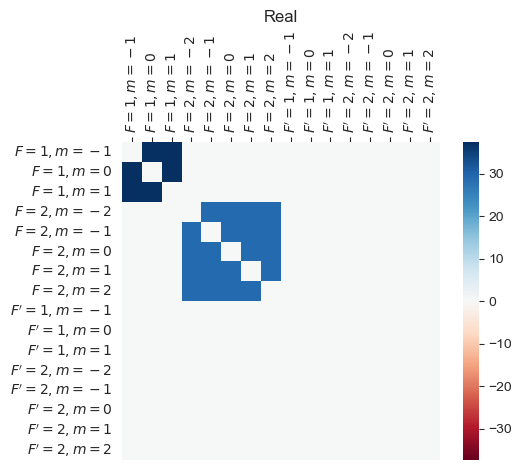

In [108]:
maplot(gamma_2_ops)


In [109]:
# starting_state = sum([basis(16, i+3).proj() for i in range(5)])
starting_state = (3 * basis(16, 7) + basis(16, 6)).proj()  # F=2, mF=2

# starting_state = basis(16, 16).proj()
starting_state = starting_state.unit()


In [110]:
times = np.linspace(0, 1e-3, 1000)
opts = Options(nsteps=1 * 10**3)
res = mesolve(
    hamil * 0,
    starting_state,
    times,
    c_ops=gamma_2_ops,
    options=opts,
)


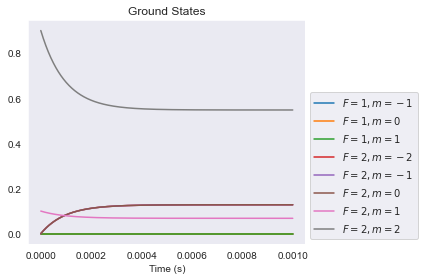

In [111]:
ground_exp = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
plt.figure()
for e in ground_exp:
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
)
plt.title("Ground States")
plt.xlabel("Time (s)")

plt.tight_layout()


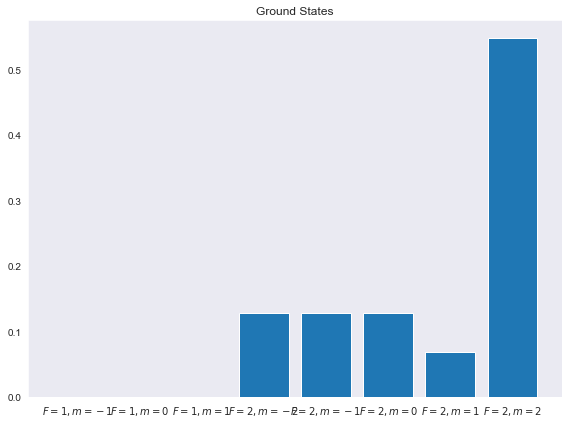

In [112]:
plt.figure(figsize=(8, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8)], [np.real(e)[-1] for e in ground_exp]
)
plt.title("Ground States")
plt.tight_layout()


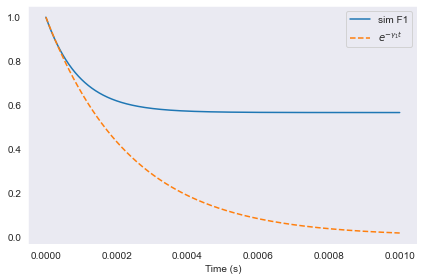

In [113]:
plt.figure()
plt.plot(
    times,
    [(res.states[t] * starting_state).tr() for t in range(len(times))],
    label="sim F1",
)
plt.plot(times, [np.exp(-gamma_2 * t) for t in times], "--", label=r"$e^{-\gamma_1 t}$")
plt.legend()
plt.xlabel("Time (s)")
plt.tight_layout()


# Wall Collisions

(<Figure size 600x480 with 2 Axes>, <AxesSubplot:title={'center':'Real'}>)

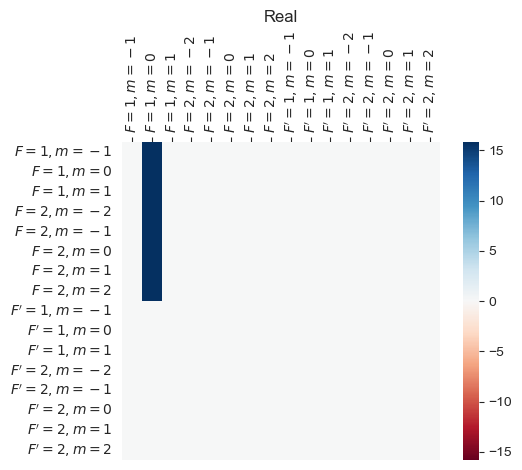

In [114]:
wall_coll_rate = 2e3
wall_ops = [
    sum(
        [
            (wall_coll_rate / 8) ** (1 / 2) * basis(16, final) * basis(16, inital).dag()
            for final in range(8)
        ]
    )
    for inital in range(8)
]
maplot(wall_ops[1])


#### starting state 1

In [115]:
# starting_state = sum([basis(16, i).proj() for i in range(8)]) # ground states equally
starting_state = basis(16, 7).proj()
starting_state = starting_state.unit()


In [116]:
times = np.linspace(0, 4e-3, 1000)
opts = Options(nsteps=1 * 10**3)
res = mesolve(
    hamil * 0,
    starting_state,
    times,
    c_ops=wall_ops,
    options=opts,
)


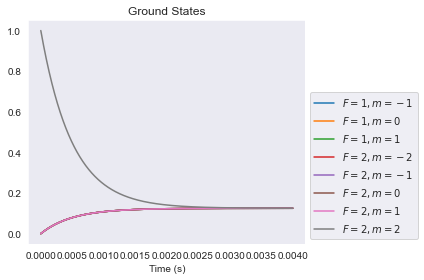

In [117]:
ground_exp = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
plt.figure()
for e in ground_exp:
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
)
plt.title("Ground States")
plt.xlabel("Time (s)")

plt.tight_layout()


#### starting state 2

(<Figure size 600x480 with 2 Axes>, <AxesSubplot:title={'center':'Real'}>)

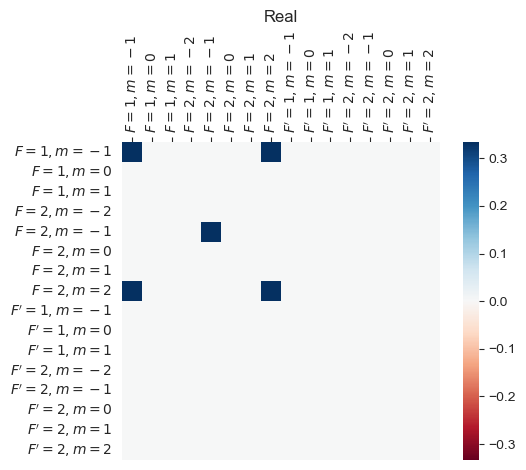

In [118]:
# starting_state = sum([basis(16, i).proj() for i in range(8)]) # ground states equally
starting_state = (basis(16, 0) + basis(16, 7)).proj() + basis(16, 4).proj()
starting_state = starting_state.unit()
maplot(starting_state)


In [119]:
times = np.linspace(0, 4e-3, 1000)
opts = Options(nsteps=1 * 10**3)
res = mesolve(
    hamil * 0,
    starting_state,
    times,
    c_ops=wall_ops,
    options=opts,
)


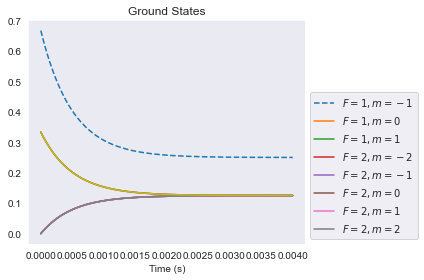

In [120]:
ground_exp = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
mw_transition_exp = [
    (res.states[t] * (basis(16, 0) + basis(16, 7)).proj().unit()).tr()
    for t, _ in enumerate(times)
]
plt.figure()
plt.plot(times, mw_transition_exp, "--", label="MW transition coherence")
for e in ground_exp:
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
)
plt.title("Ground States")
plt.xlabel("Time (s)")

plt.tight_layout()


#### starting state 3

In [121]:
# starting_state = sum([basis(16, i).proj() for i in range(8)]) # ground states equally
starting_state = sum([random.random() * basis(16, k).proj() for k in range(8)])
starting_state = starting_state.unit()


In [122]:
times = np.linspace(0, 4e-3, 1000)
opts = Options(nsteps=1 * 10**3)
res = mesolve(
    hamil * 0,
    starting_state,
    times,
    c_ops=wall_ops,
    options=opts,
)


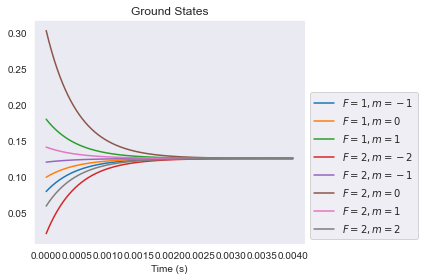

In [123]:
ground_exp = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
plt.figure()
for e in ground_exp:
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
)
plt.title("Ground States")
plt.xlabel("Time (s)")

plt.tight_layout()


In [124]:
from IPython.display import display


# Decay intra F 

$ |F, m_F \rangle \rightarrow |F, m'_F \rangle$ , where $m'_F = -F, ..., F$ and $m_F \neq m'_F$

Decay operator $C_k = \sqrt{\Gamma_k} \sum_{m'_F\neq k} |F, m'_F \rangle \langle F, m_F=k |$


(<Figure size 600x480 with 2 Axes>, <AxesSubplot:title={'center':'Real'}>)

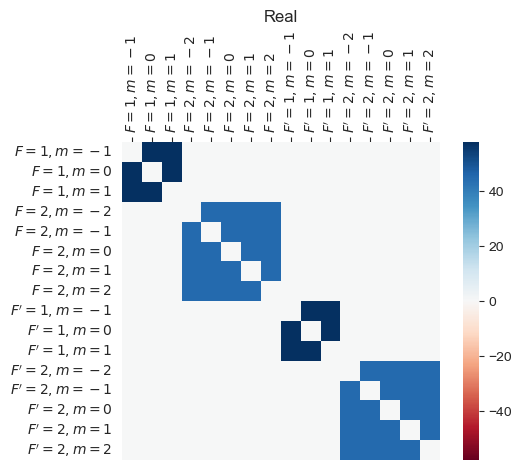

In [125]:
maplot(sum(intra_F1 + intra_F2 + intra_Fp1 + intra_Fp2))


(<Figure size 600x480 with 2 Axes>, <AxesSubplot:title={'center':'Real'}>)

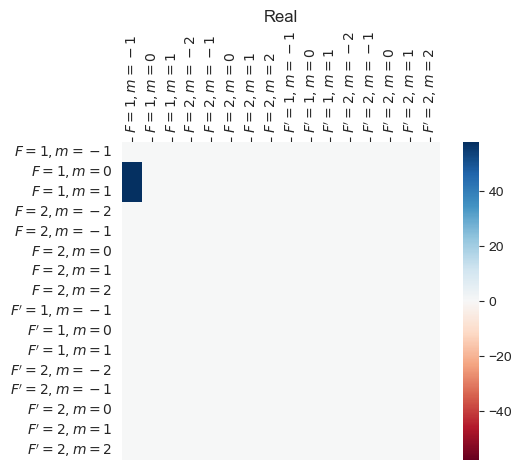

In [126]:
maplot(intra_F1[0])


## Time Evo

In [127]:
L = liouvillian(0 * hamil, c_ops=intra_F1 + intra_F2 + intra_Fp1 + intra_Fp2)


In [128]:
starting_state = basis(16, 7).proj()
starting_state = starting_state.unit()


In [129]:
times = np.linspace(0, 1e-4, 1001)
opts = Options(nsteps=1 * 10**6)
res = mesolve(
    L,
    starting_state,
    times,
    options=opts,
)


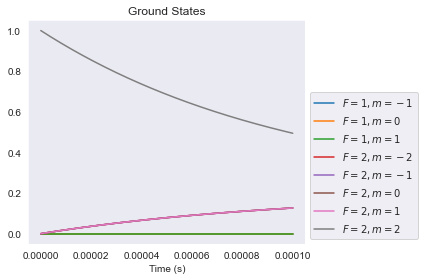

In [130]:
ground_exp_even = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
plt.figure()
for i, e in enumerate(ground_exp_even):
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
)
plt.title("Ground States")
plt.xlabel("Time (s)")

plt.tight_layout()


## With Laser, Without Rad Decay

### liouvillian

In [131]:
L = liouvillian(hamil, c_ops=intra_F1 + intra_F2 + intra_Fp1 + intra_Fp2)


In [132]:
vector_to_operator(L * operator_to_vector(rand_dm(16))).tr()


(-2.717115421546623e-11-7.275957614183426e-12j)

In [133]:
vector_to_operator(L * operator_to_vector(basis(16, 7).proj())).tr()


0.0

$\dot{\rho} (t=0)$, where $\rho (0) = |F=2, m_F=2 \rangle$

(<Figure size 1680x672 with 4 Axes>,
 [<AxesSubplot:title={'center':'Real'}>,
  <AxesSubplot:title={'center':'Imag'}>])

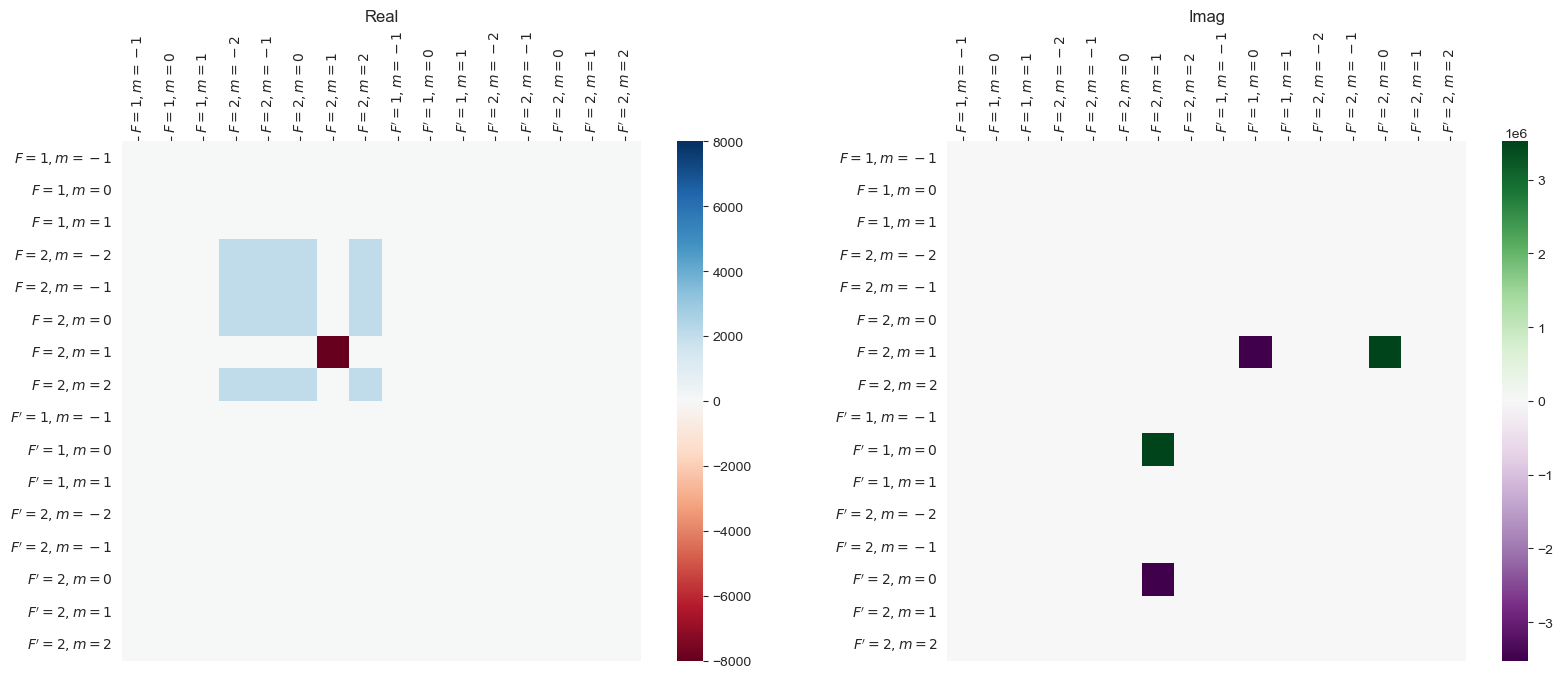

In [134]:
maplot(vector_to_operator(L * operator_to_vector(basis(16, 6).proj())))


In [135]:
import plotly.express as px

y = L.full().real
fig = px.imshow(
    y,
    color_continuous_midpoint=0,
    aspect="equal",
    width=1.5 * 800,
    height=1.5 * 400,
    zmin=-(abs(y).max()),
    zmax=(abs(y).max()),
    color_continuous_scale="RdBu",
)
fig.show()


### Steady State

In [136]:
L_en, L_states = L.eigenstates()


c:\Users\m\anaconda3\envs\masterarbeit_python39\lib\site-packages\seaborn\categorical.py:128: ComplexWarning:

Casting complex values to real discards the imaginary part



<AxesSubplot:>

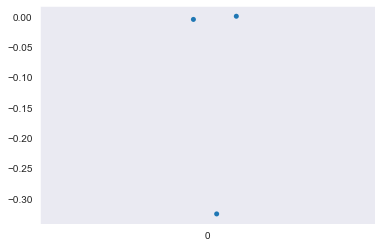

In [137]:
sns.stripplot(data=L_en[np.where(np.abs(L_en) < 1e1)])


In [138]:
L_en[np.where(np.abs(L_en) < 1e1)]


array([-3.25350303e-01-5.82792886e-08j, -5.20475352e-03-1.71101446e-07j,
        2.91171183e-07-1.33338756e-07j])

In [139]:
zero_eigenval_states = []
for nr, en in enumerate(L_en):
    if np.abs(en) < 1e-1:
        zero_eigenval_states.append((en, vector_to_operator(L_states[nr])))


In [140]:
len(zero_eigenval_states)


2

In [141]:
zero_eigenval_states[0][0]


(-0.0052047535201342416-1.7110144568883392e-07j)

In [142]:
zero_eigenval_states[-1][0]


(2.911711833931967e-07-1.3333875612402766e-07j)

In [143]:
zero_eigenval_states[-1][-1].tr()


(3.2327823424428854+0.00016037838885812897j)

In [144]:
zero_eigenval_states[0][-1].tr()


(-0.000319491281428233+2.84020558484338e-05j)

### Time Evo 

In [145]:
starting_state = sum([basis(16, i).proj() for i in range(8)])  # ground states equally
# starting_state = basis(16, 7).proj()
starting_state = starting_state.unit()


In [146]:
vector_to_operator(L * operator_to_vector(starting_state)).tr()


-8.526512829121202e-14

(<Figure size 1680x672 with 4 Axes>,
 [<AxesSubplot:title={'center':'Real'}>,
  <AxesSubplot:title={'center':'Imag'}>])

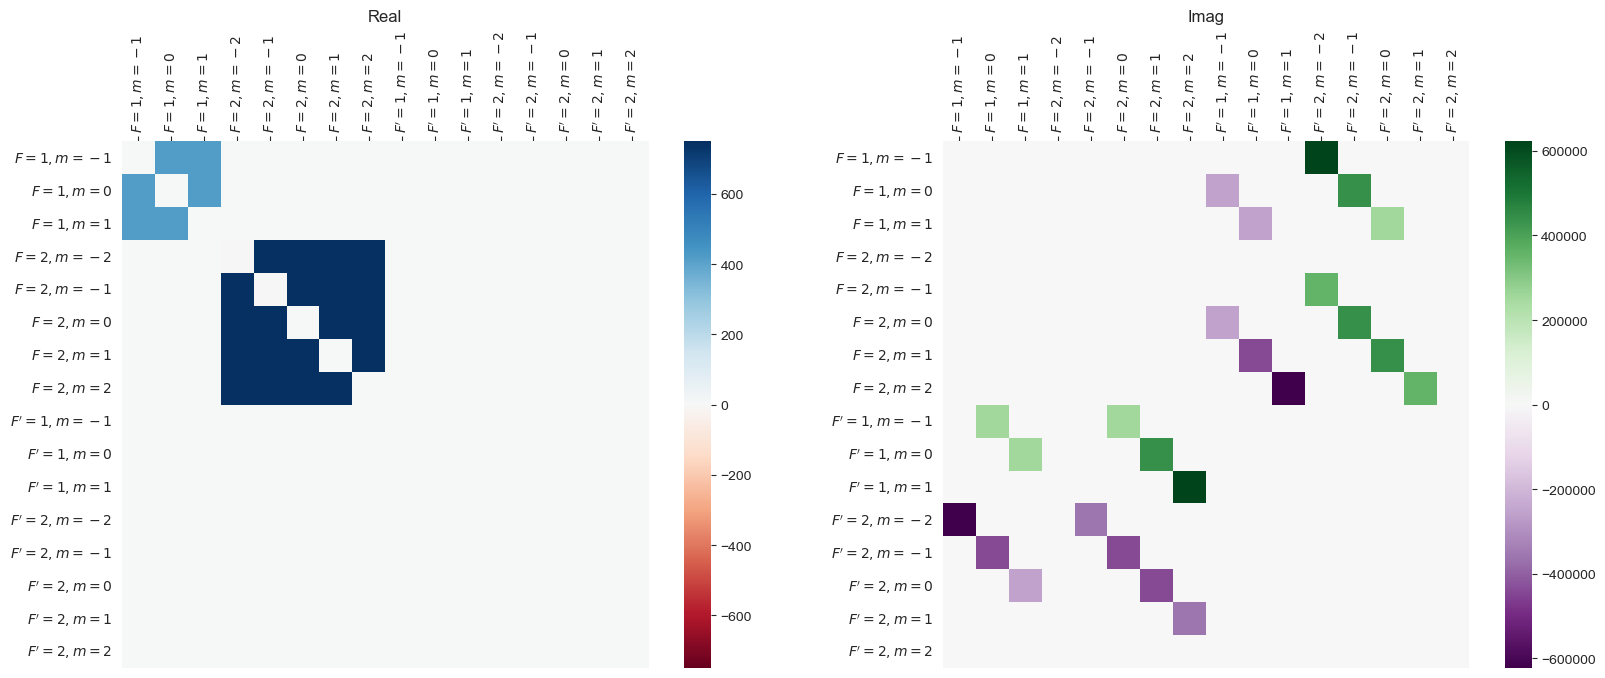

In [147]:
maplot(vector_to_operator(L * operator_to_vector(starting_state)))


In [148]:
times = np.linspace(0, 1e-5, 1001)
opts = Options(nsteps=1 * 10**6)
res = mesolve(
    L,
    starting_state,
    times,
    options=opts,
)


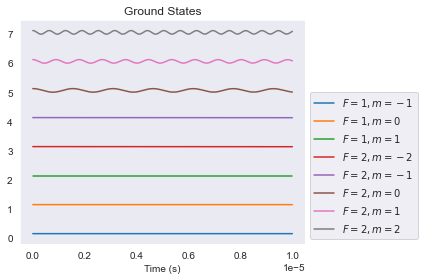

In [149]:
ground_exp_even = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
plt.figure()
for i, e in enumerate(ground_exp_even):
    plt.plot(times, np.real(e) + i)
plt.legend(
    [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
)
plt.title("Ground States")
plt.xlabel("Time (s)")

plt.tight_layout()


c:\Users\m\anaconda3\envs\masterarbeit_python39\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning:

Casting complex values to real discards the imaginary part



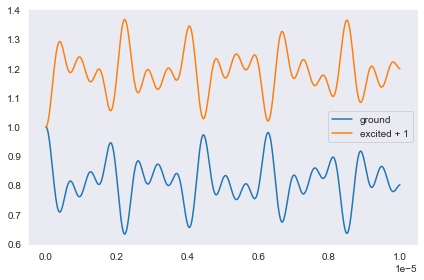

In [150]:
ground_state_even = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(8)
        ]
    )
    for t in range(len(times))
]
tot_excited_exp_even = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(8, 16)
        ]
    )
    + 1
    for t in range(len(times))
]
fig, ax = plt.subplots()
ax.plot(times, ground_state_even, label="ground")
ax.plot(times, tot_excited_exp_even, label="excited + 1")
ax.legend()
plt.tight_layout()


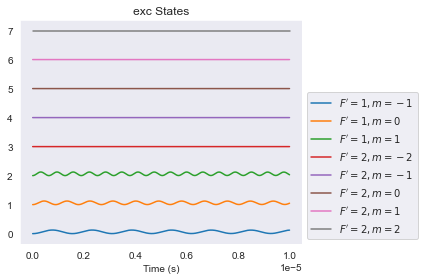

In [151]:
exc_expeven = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8, 16)
]
plt.figure()
for k, e in enumerate(exc_expeven):
    plt.plot(times, np.real(e) + k)
plt.legend(
    [index_to_F_mF_string(i) for i in range(8, 16)],
    loc="best",
    bbox_to_anchor=(1.0, 0.7),
)
plt.title("exc States")
plt.xlabel("Time (s)")

plt.tight_layout()


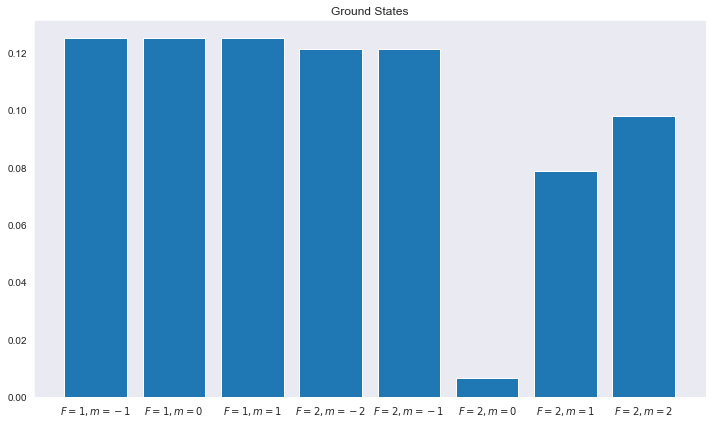

In [152]:
plt.figure(figsize=(10, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8)],
    [np.real(e)[-1] for e in ground_exp_even],
)
plt.title("Ground States")
plt.tight_layout()


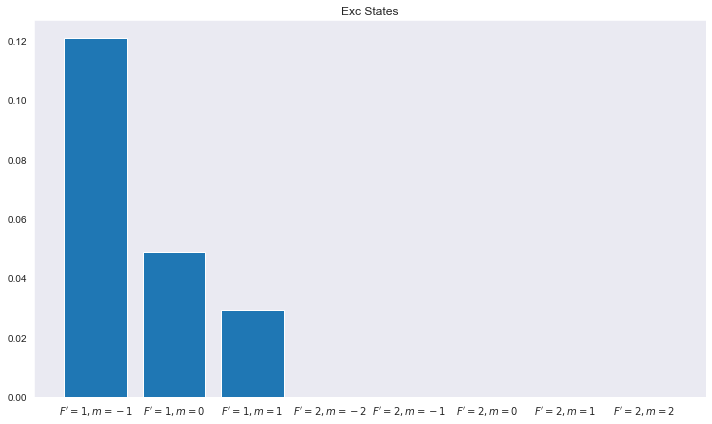

In [153]:
plt.figure(figsize=(10, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8, 16)],
    [np.real(e)[-1] for e in exc_expeven],
)
plt.title("Exc States")
plt.tight_layout()


#### $\rho_0 = |F=2, m_F=2 \rangle \langle F=2, m_F=2|$ 

In [154]:
# starting_state = sum([basis(16, i).proj() for i in range(8)]) # ground states equally
starting_state = basis(16, 7).proj()
starting_state = starting_state.unit()


In [155]:
times = np.linspace(0, 1e-5, 1001)
opts = Options(nsteps=1 * 10**6)
res = mesolve(
    L,
    starting_state,
    times,
    options=opts,
)


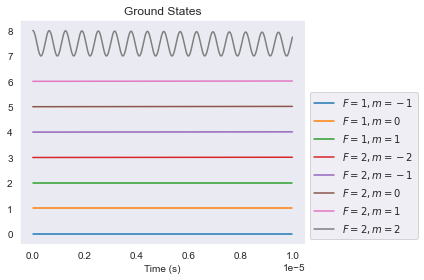

In [156]:
ground_exp = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
plt.figure()
for i, e in enumerate(ground_exp):
    plt.plot(times, np.real(e) + i)
plt.legend(
    [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
)
plt.title("Ground States")
plt.xlabel("Time (s)")

plt.tight_layout()


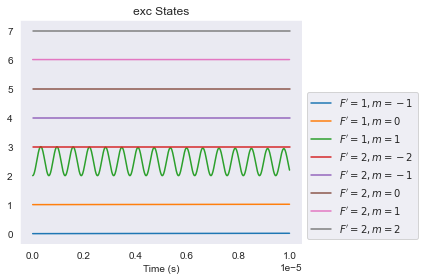

In [157]:
exc_exp = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8, 16)
]
plt.figure()
for i, e in enumerate(exc_exp):
    plt.plot(times, np.real(e) + i)
plt.legend(
    [index_to_F_mF_string(i) for i in range(8, 16)],
    loc="best",
    bbox_to_anchor=(1.0, 0.7),
)
plt.title("exc States")
plt.xlabel("Time (s)")

plt.tight_layout()


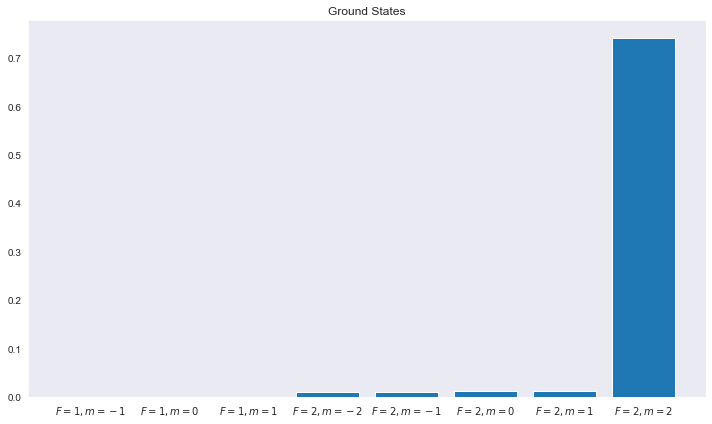

In [158]:
plt.figure(figsize=(10, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8)], [np.real(e)[-1] for e in ground_exp]
)
plt.title("Ground States")
plt.tight_layout()


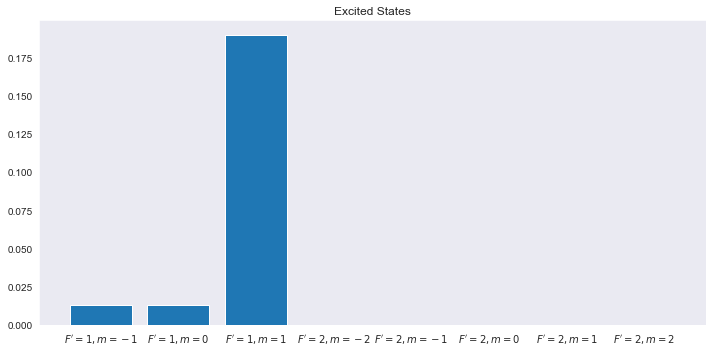

In [159]:
plt.figure(figsize=(10, 5))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8, 16)], [np.real(e)[-1] for e in exc_exp]
)
plt.title("Excited States")
plt.tight_layout()


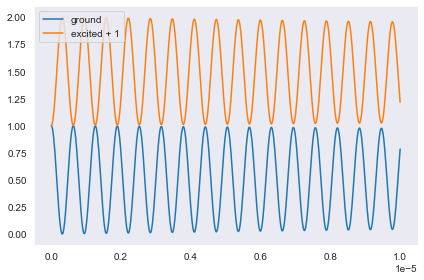

In [160]:
ground_state = [sum(np.array(ground_exp)[:, t]).real for t in range(len(times))]
tot_excited_exp = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i)).real
            for i in range(8, 16)
        ]
    )
    + 1
    for t in range(len(times))
]
fig, ax = plt.subplots()
ax.plot(times, ground_state, label="ground")
ax.plot(times, tot_excited_exp, label="excited + 1")
ax.legend()
plt.tight_layout()


## With Rad Decay

In [161]:
L = liouvillian(
    hamil,
    c_ops=intra_F1 + intra_F2 + intra_Fp1 + intra_Fp2 + natural_decay_ops,
)


In [162]:
L_en, L_states = L.eigenstates()


In [163]:
import plotly.express as px

y = L.full().real
fig = px.imshow(
    y,
    color_continuous_midpoint=0,
    aspect="equal",
    width=1.5 * 800,
    height=1.5 * 400,
    zmin=-(abs(y).max()),
    zmax=(abs(y).max()),
    color_continuous_scale="RdBu",
)
fig.show()


In [164]:
sorted(np.abs(L_en))[:10]


[1.0400738090735148e-06,
 2006.43370350121,
 6744.909078984909,
 6744.909080083952,
 6754.660922201028,
 6754.660922339302,
 6989.843573541444,
 6989.8435741127105,
 10000.946150294065,
 10001.38570925418]

In [165]:
zero_eigenvalue_states = []
for en, st in zip(*L.eigenstates()):
    if np.isclose(en, 0, atol=1e-5):
        zero_eigenvalue_states.append(vector_to_operator(st))


In [166]:
len(zero_eigenvalue_states)


1

(1.4258857131497134+7.814333678043584e-11j)


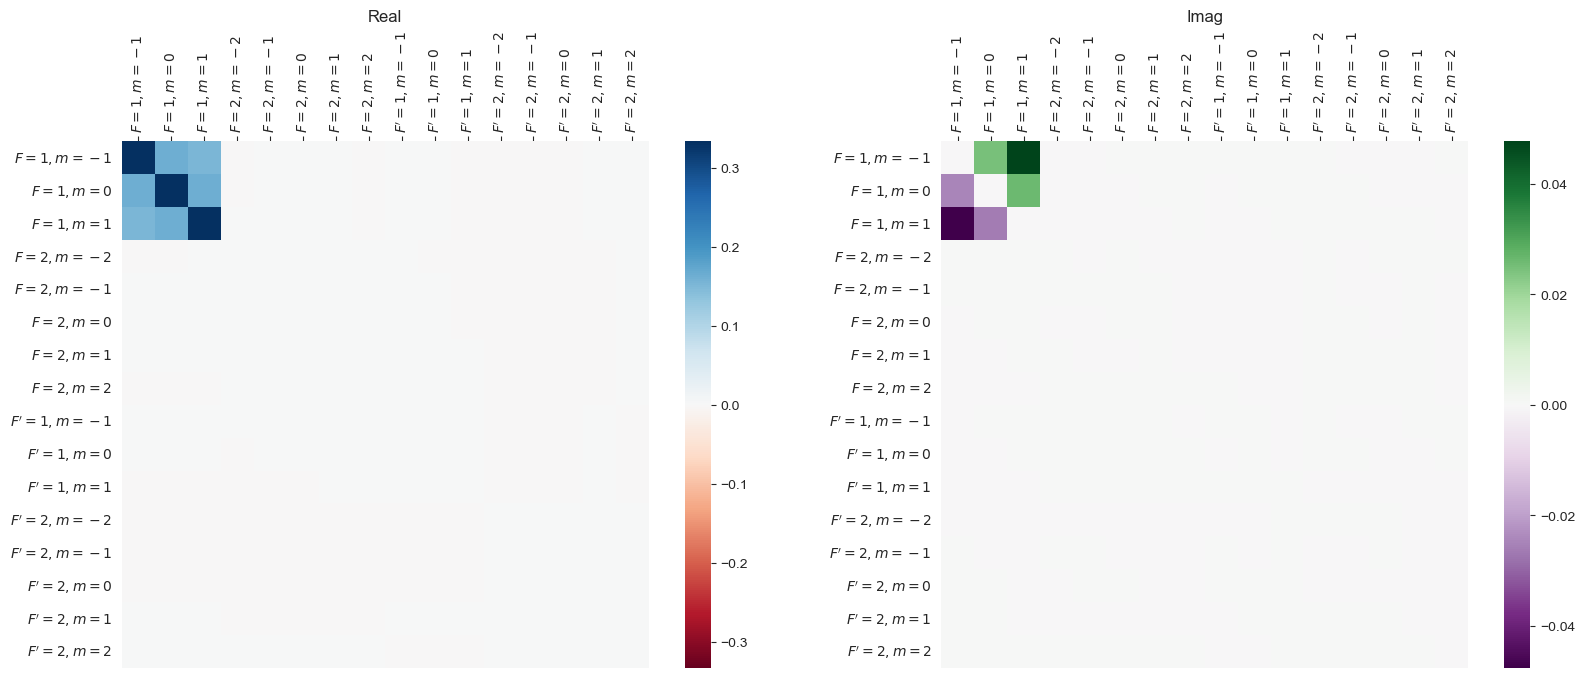

In [167]:
trace = zero_eigenvalue_states[0].tr()
maplot(zero_eigenvalue_states[0] / trace)
print(trace)


In [168]:
rho_steady = zero_eigenvalue_states[0] / trace
rho_steady_dot = vector_to_operator(L * operator_to_vector(rho_steady))


In [169]:
rho_steady_dot.tr()


(-1.9575600540605432e-13+2.7642122701169926e-13j)

(<Figure size 1680x672 with 4 Axes>,
 [<AxesSubplot:title={'center':'Real'}>,
  <AxesSubplot:title={'center':'Imag'}>])

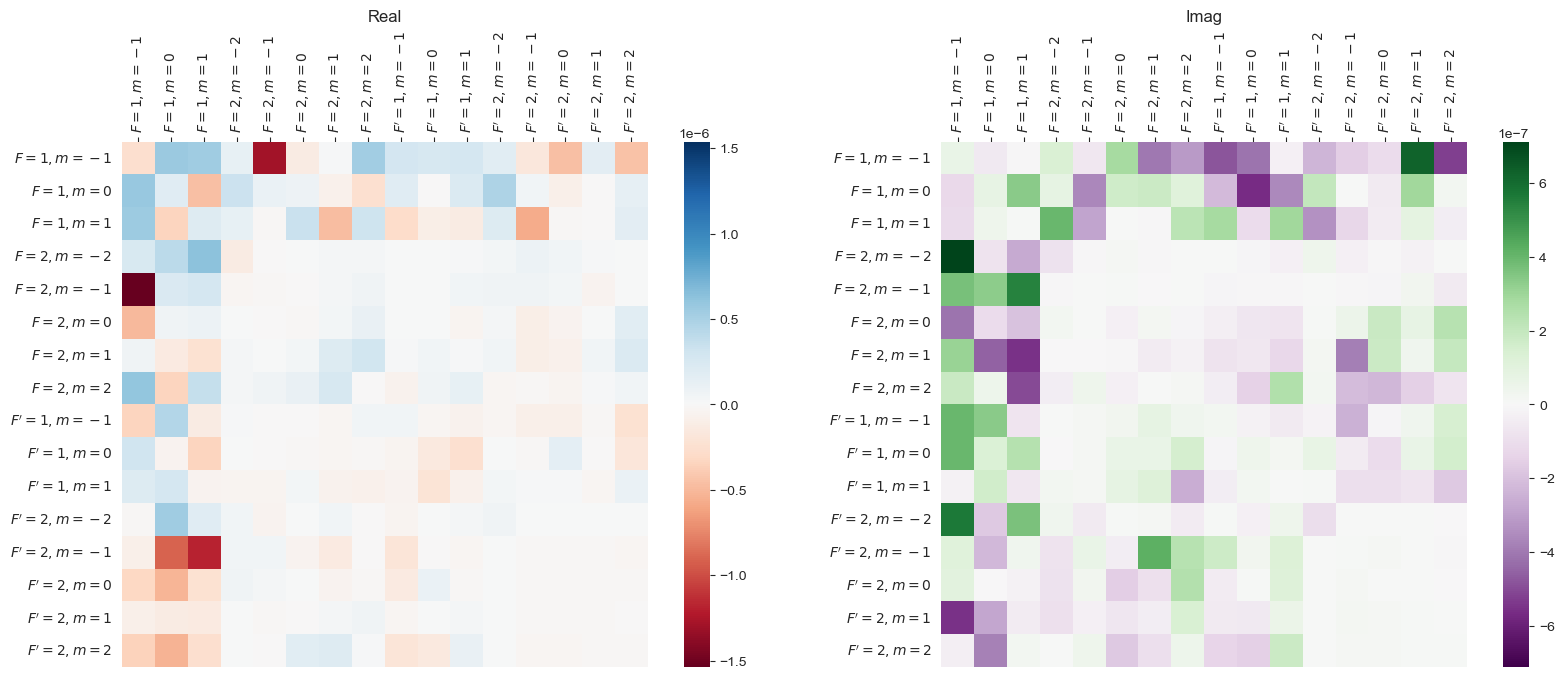

In [170]:
maplot(rho_steady_dot)


Text(0.5, 0.98, 'Eigenvalue = 5.2e-03')

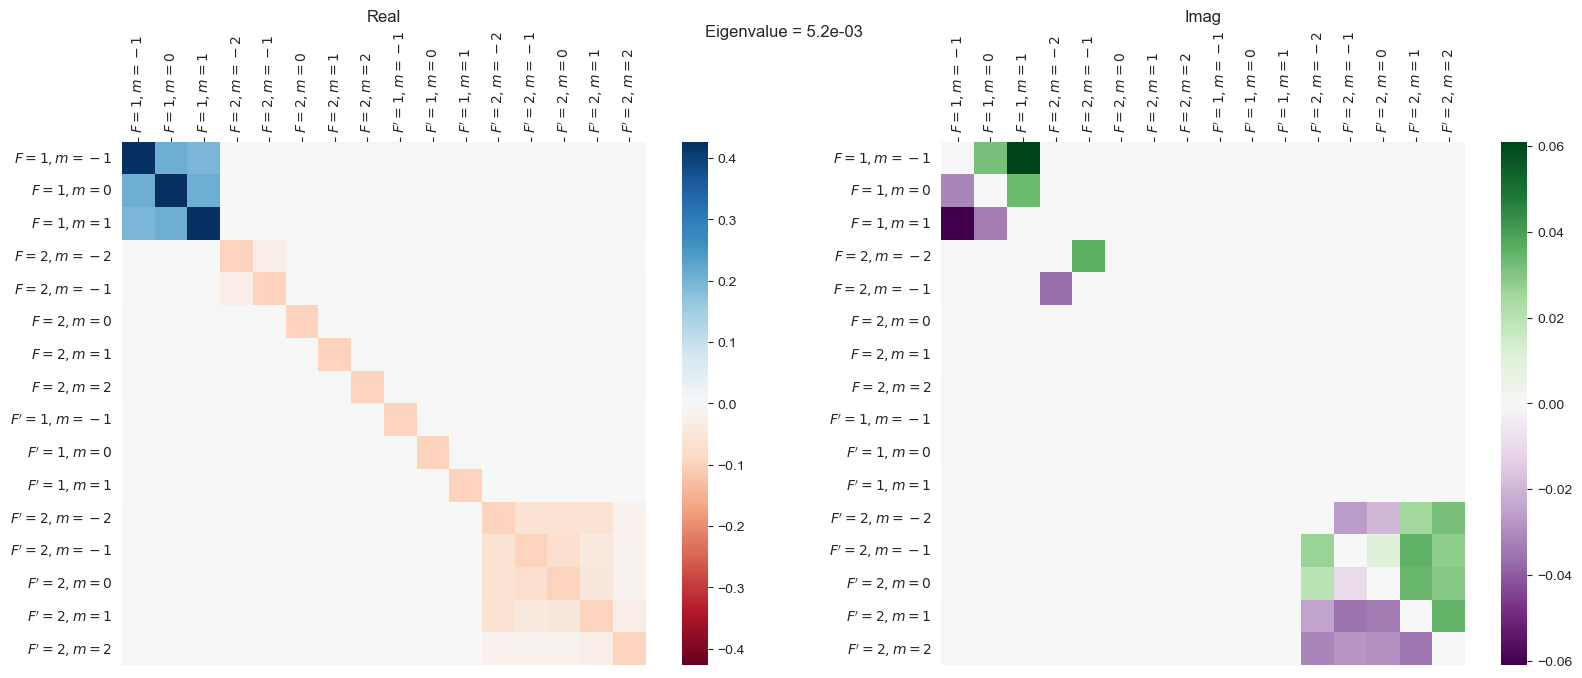

In [171]:
fig, axs = maplot(zero_eigenval_states[0][1])
fig.suptitle(f"Eigenvalue = {abs(zero_eigenval_states[0][0]):.1e}")


### Time Evo

In [172]:
starting_state = sum([basis(16, i).proj() for i in range(8)])  # ground states equally
# starting_state = basis(16, 7).proj()
starting_state = starting_state.unit()


In [173]:
starting_state = sum([basis(16, i).proj() for i in range(8)])  # ground states equally
# starting_state = basis(16, 7).proj()
starting_state = starting_state.unit()


In [174]:
times = np.linspace(0, 1e-6, 1001)
opts = Options(nsteps=1 * 10**3)
res = mesolve(
    L,
    starting_state,
    times,
    options=opts,
)


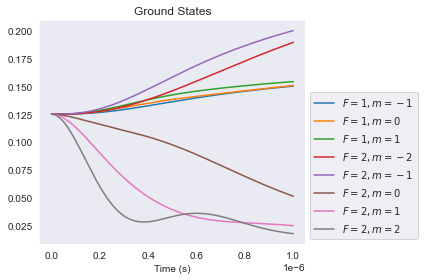

In [175]:
ground_exp_even = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
plt.figure()
for i, e in enumerate(ground_exp_even):
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
)
plt.title("Ground States")
plt.xlabel("Time (s)")

plt.tight_layout()


c:\Users\m\anaconda3\envs\masterarbeit_python39\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning:

Casting complex values to real discards the imaginary part



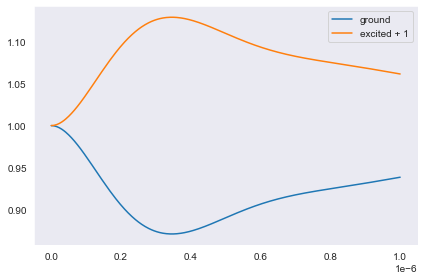

In [176]:
ground_state_even = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(8)
        ]
    )
    for t in range(len(times))
]
tot_excited_exp_even = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(8, 16)
        ]
    )
    + 1
    for t in range(len(times))
]
fig, ax = plt.subplots()
ax.plot(times, ground_state_even, label="ground")
ax.plot(times, tot_excited_exp_even, label="excited + 1")
ax.legend()
plt.tight_layout()


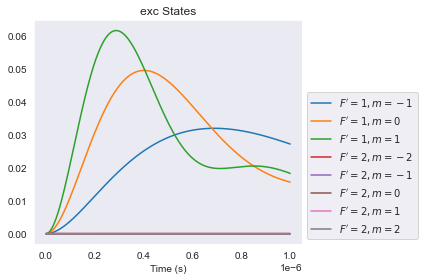

In [177]:
exc_expeven = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8, 16)
]
plt.figure()
for k, e in enumerate(exc_expeven):
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8, 16)],
    loc="best",
    bbox_to_anchor=(1.0, 0.7),
)
plt.title("exc States")
plt.xlabel("Time (s)")

plt.tight_layout()


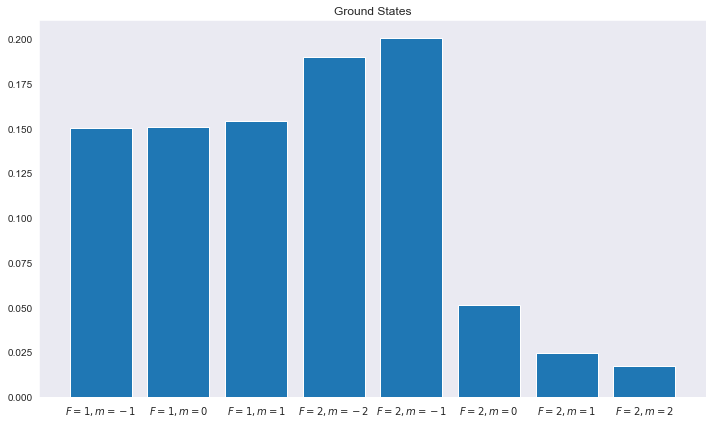

In [178]:
plt.figure(figsize=(10, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8)],
    [np.real(e)[-1] for e in ground_exp_even],
)
plt.title("Ground States")
plt.tight_layout()


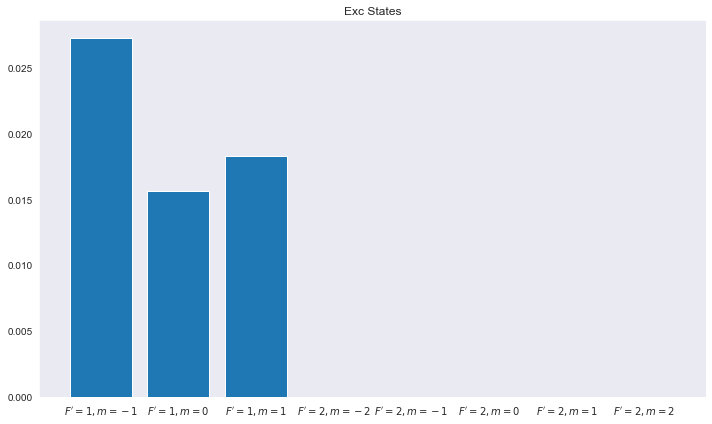

In [179]:
plt.figure(figsize=(10, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8, 16)],
    [np.real(e)[-1] for e in exc_expeven],
)
plt.title("Exc States")
plt.tight_layout()


# Decay Inter F Ground States

(<Figure size 600x480 with 2 Axes>, <AxesSubplot:title={'center':'Real'}>)

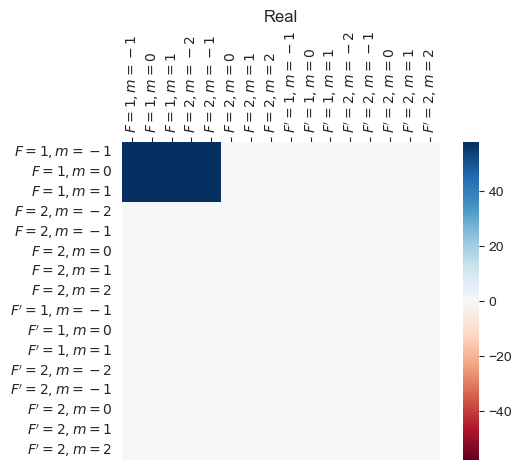

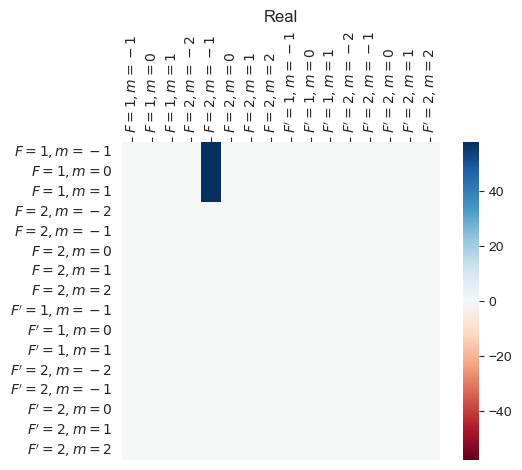

In [180]:
maplot(sum(F2_to_F1_decay_ops))
maplot(F2_to_F1_decay_ops[-1])


# Radiative and F to F and F=2 to F=1 and Quenching

In [181]:
L = liouvillian(
    hamil,
    c_ops=natural_decay_ops + intra_F1 + intra_F2 + F2_to_F1_decay_ops + quenching_ops,
)


Real part

In [182]:
import plotly.express as px

y = L.full().real
fig = px.imshow(
    y,
    color_continuous_midpoint=0,
    aspect="equal",
    width=1.5 * 800,
    height=1.5 * 400,
    zmin=-(abs(y).max()),
    zmax=(abs(y).max()),
    color_continuous_scale="RdBu",
)
fig.show()


Imag part

In [183]:
import plotly.express as px

y = L.full().imag
fig = px.imshow(
    y,
    color_continuous_midpoint=0,
    aspect="equal",
    width=1.5 * 800,
    height=1.5 * 400,
    zmin=-(abs(y).max()),
    zmax=(abs(y).max()),
    color_continuous_scale="RdBu",
)
fig.show()


In [184]:
L_eigvals, L_states = L.eigenstates()


<AxesSubplot:>

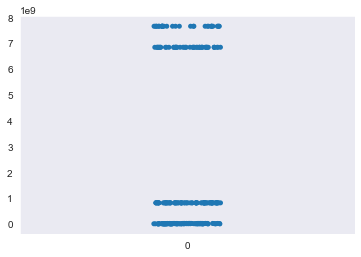

In [185]:
sns.stripplot(data=abs(L_eigvals))


In [186]:
abs(L_eigvals).min()


1.6595678440361655e-06

In [187]:
sorted(abs(L_eigvals))[:10]


[1.6595678440361655e-06,
 13199.28604533847,
 16703.689232017874,
 16703.689232053337,
 16705.736006122115,
 16705.73600825457,
 16803.15125194996,
 16803.151253039796,
 20003.853581695494,
 20006.237595261016]

(<Figure size 1680x672 with 4 Axes>,
 [<AxesSubplot:title={'center':'Real'}>,
  <AxesSubplot:title={'center':'Imag'}>])

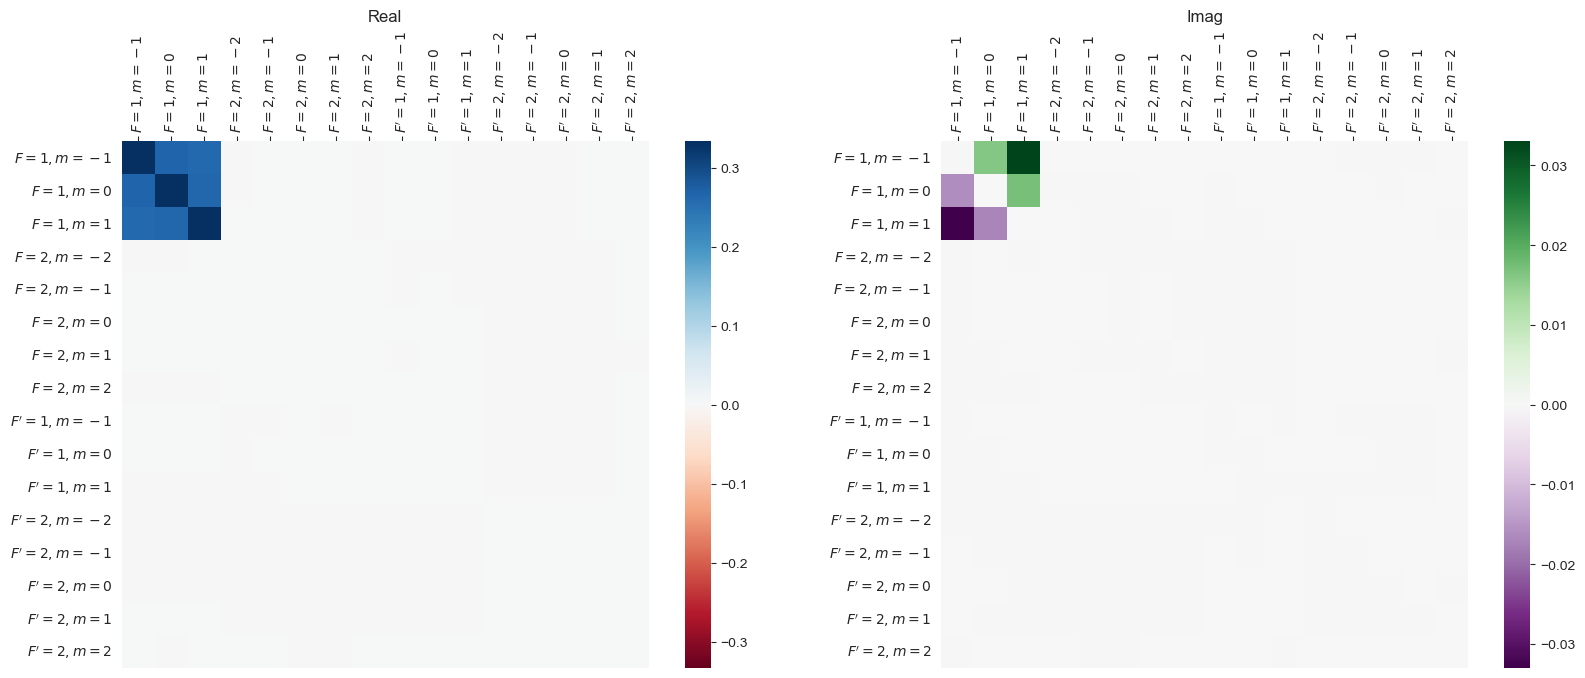

In [188]:
r_zero = L_states[abs(L_eigvals).argmin()]
r_zero = vector_to_operator(r_zero)
maplot(r_zero / r_zero.tr())


## Time Evo

In [189]:
rho_zero = sum([basis(16, i).proj() for i in range(8)]).unit()  # equally distrib


In [190]:
times = np.linspace(0, 1e-6, 1001)
opts = Options(nsteps=1 * 10**3)
res = mesolve(
    L,
    rho_zero,
    times,
    options=opts,
)


(<Figure size 1680x672 with 4 Axes>,
 [<AxesSubplot:title={'center':'Real'}>,
  <AxesSubplot:title={'center':'Imag'}>])

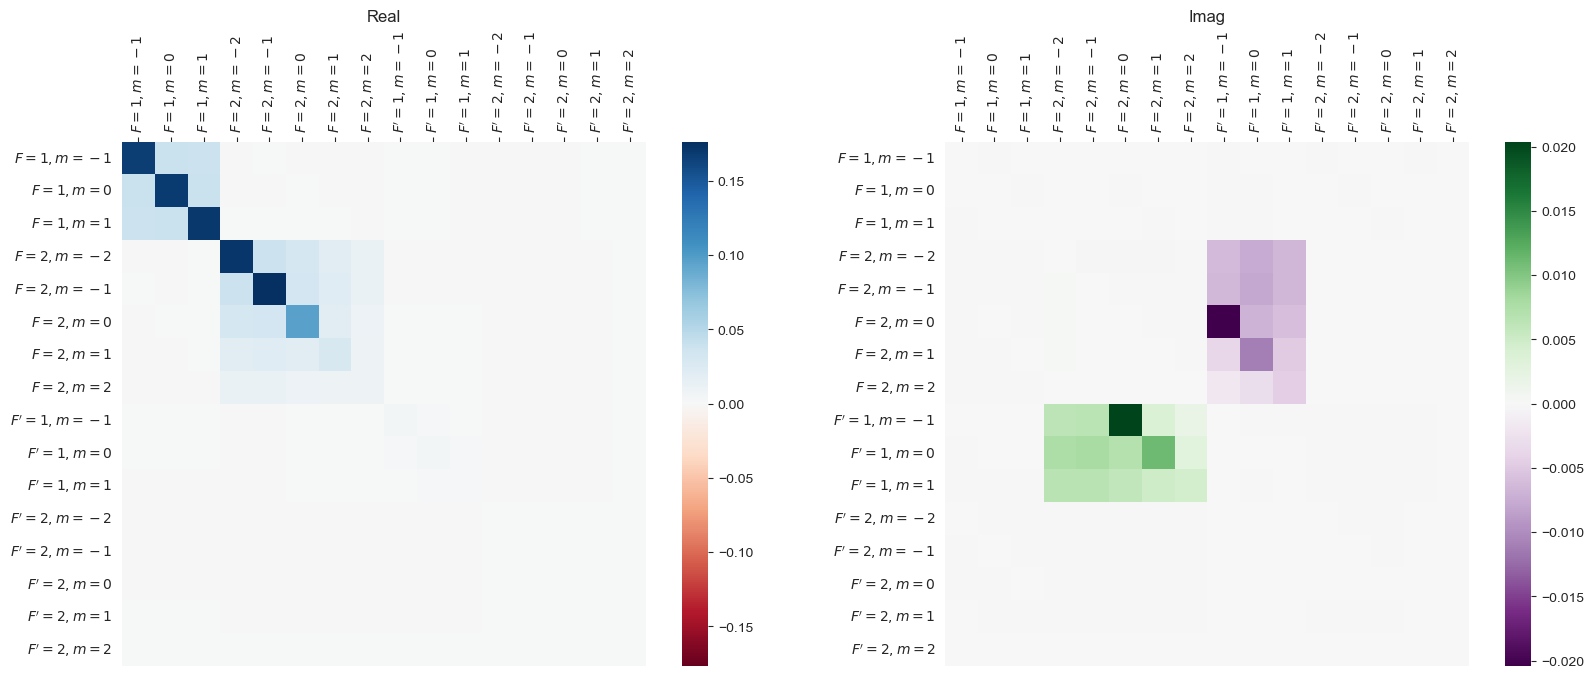

In [191]:
maplot(res.states[-1])


In [192]:
res.states[-1].tr()


0.9999999999999986

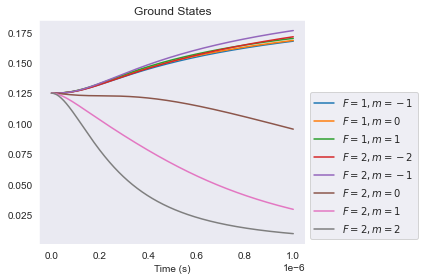

In [193]:
ground_exp_even = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
plt.figure()
for i, e in enumerate(ground_exp_even):
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
)
plt.title("Ground States")
plt.xlabel("Time (s)")

plt.tight_layout()


c:\Users\m\anaconda3\envs\masterarbeit_python39\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning:

Casting complex values to real discards the imaginary part



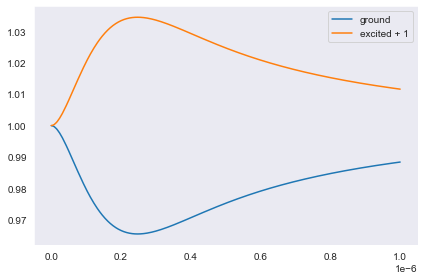

In [194]:
ground_state_tot = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(8)
        ]
    )
    for t in range(len(times))
]
tot_excited_exp_even = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(8, 16)
        ]
    )
    + 1
    for t in range(len(times))
]
fig, ax = plt.subplots()
ax.plot(times, ground_state_tot, label="ground")
ax.plot(times, tot_excited_exp_even, label="excited + 1")
ax.legend()
plt.tight_layout()


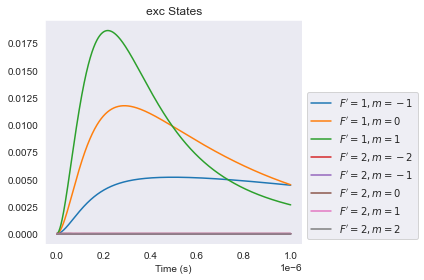

In [195]:
exc_expeven = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8, 16)
]
plt.figure()
for k, e in enumerate(exc_expeven):
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8, 16)],
    loc="best",
    bbox_to_anchor=(1.0, 0.7),
)
plt.title("exc States")
plt.xlabel("Time (s)")

plt.tight_layout()


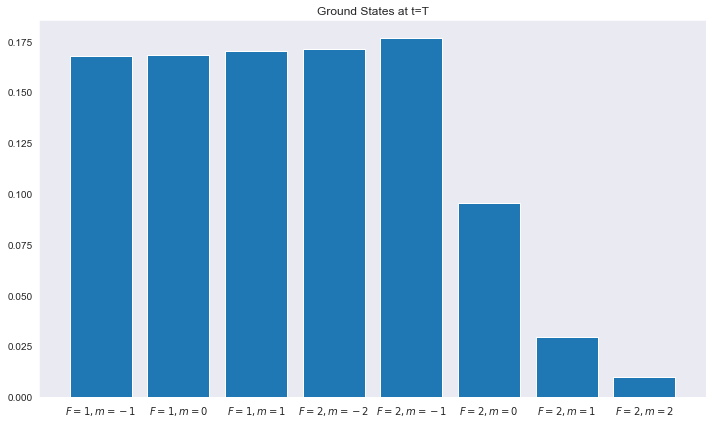

In [196]:
plt.figure(figsize=(10, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8)],
    [np.real(e)[-1] for e in ground_exp_even],
)
plt.title("Ground States at t=T")
plt.tight_layout()


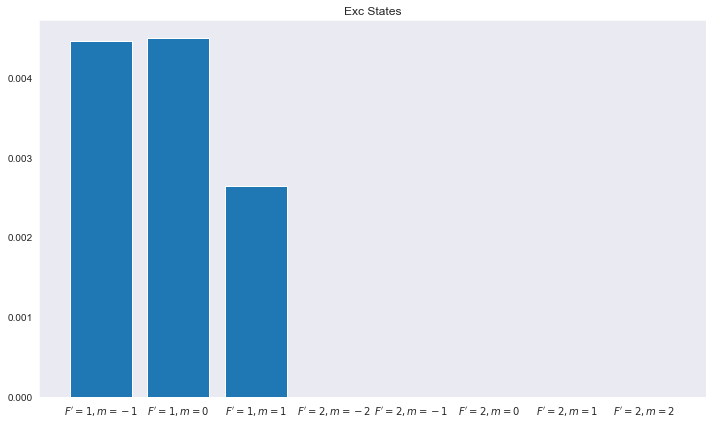

In [197]:
plt.figure(figsize=(10, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8, 16)],
    [np.real(e)[-1] for e in exc_expeven],
)
plt.title("Exc States")
plt.tight_layout()


## Longer Time Evo

In [198]:
rho_zero = sum([basis(16, i).proj() for i in range(8)]).unit()  # equally distrib


In [199]:
times = np.linspace(0, 1e-5, 1001)
opts = Options(nsteps=1 * 10**4)
res = mesolve(
    L,
    rho_zero,
    times,
    options=opts,
)


(<Figure size 1680x672 with 4 Axes>,
 [<AxesSubplot:title={'center':'Real'}>,
  <AxesSubplot:title={'center':'Imag'}>])

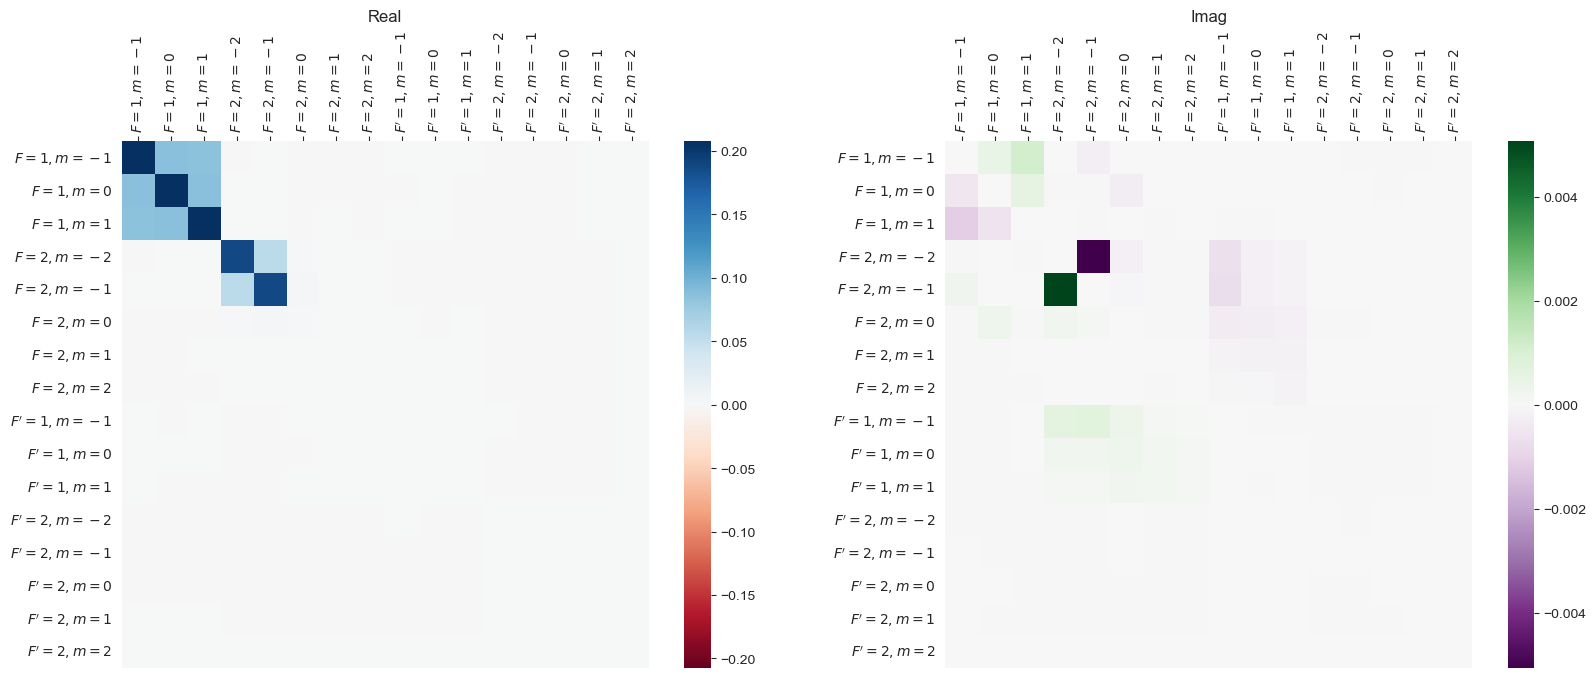

In [200]:
maplot(res.states[-1])


In [201]:
res.states[-1].tr()


1.0000000000000049

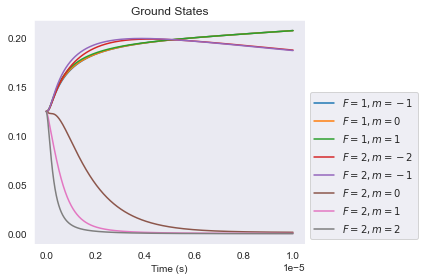

In [202]:
ground_exp_even = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
plt.figure()
for i, e in enumerate(ground_exp_even):
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
)
plt.title("Ground States")
plt.xlabel("Time (s)")

plt.tight_layout()


c:\Users\m\anaconda3\envs\masterarbeit_python39\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning:

Casting complex values to real discards the imaginary part



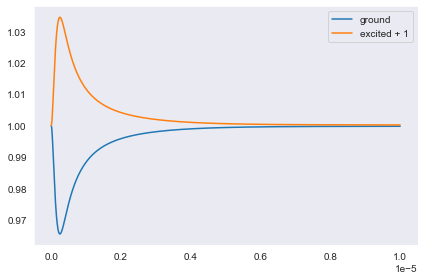

In [203]:
ground_state_tot = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(8)
        ]
    )
    for t in range(len(times))
]
tot_excited_exp_even = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(8, 16)
        ]
    )
    + 1
    for t in range(len(times))
]
fig, ax = plt.subplots()
ax.plot(times, ground_state_tot, label="ground")
ax.plot(times, tot_excited_exp_even, label="excited + 1")
ax.legend()
plt.tight_layout()


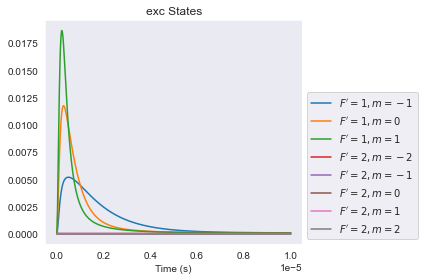

In [204]:
exc_expeven = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8, 16)
]
plt.figure()
for k, e in enumerate(exc_expeven):
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8, 16)],
    loc="best",
    bbox_to_anchor=(1.0, 0.7),
)
plt.title("exc States")
plt.xlabel("Time (s)")

plt.tight_layout()


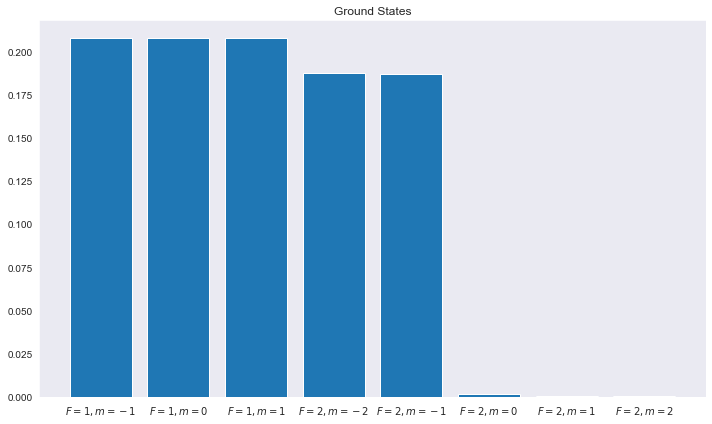

In [205]:
plt.figure(figsize=(10, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8)],
    [np.real(e)[-1] for e in ground_exp_even],
)
plt.title("Ground States")
plt.tight_layout()


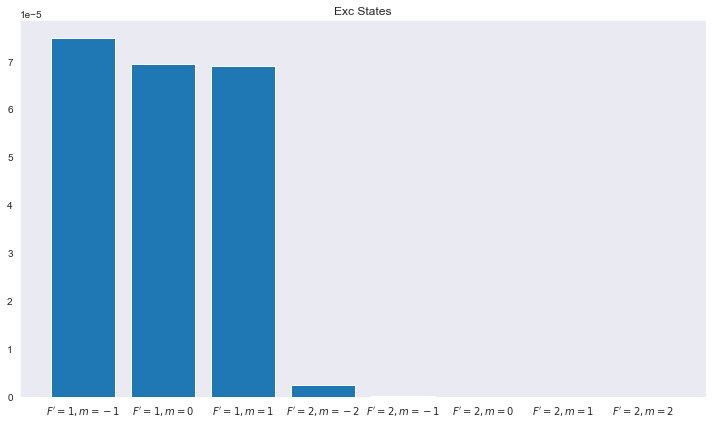

In [206]:
plt.figure(figsize=(10, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8, 16)],
    [np.real(e)[-1] for e in exc_expeven],
)
plt.title("Exc States")
plt.tight_layout()


## $\rho_0 = |F=2, m_F=-2\rangle$

In [207]:
rho_zero = sum([basis(16, 3).proj() for i in range(8)]).unit()


In [208]:
times = np.linspace(0, 1e-5, 1001)
opts = Options(nsteps=1 * 10**4)
res = mesolve(
    L,
    rho_zero,
    times,
    options=opts,
)


(<Figure size 1680x672 with 4 Axes>,
 [<AxesSubplot:title={'center':'Real'}>,
  <AxesSubplot:title={'center':'Imag'}>])

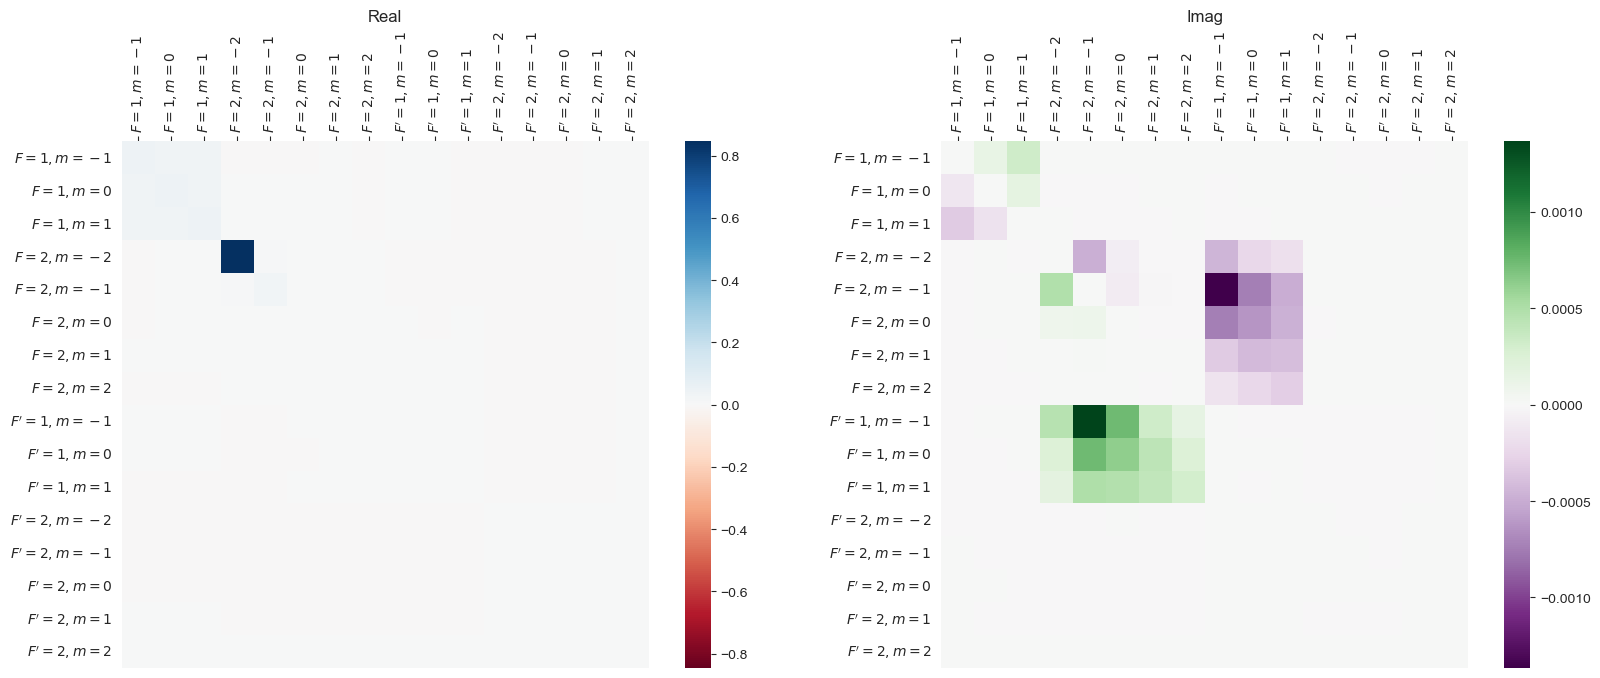

In [209]:
maplot(res.states[-1])


In [210]:
res.states[-1].tr()


1.000000000000019

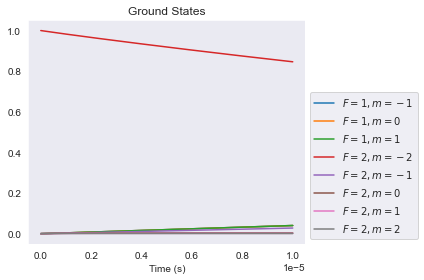

In [211]:
ground_exp_even = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
plt.figure()
for i, e in enumerate(ground_exp_even):
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
)
plt.title("Ground States")
plt.xlabel("Time (s)")

plt.tight_layout()


c:\Users\m\anaconda3\envs\masterarbeit_python39\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning:

Casting complex values to real discards the imaginary part



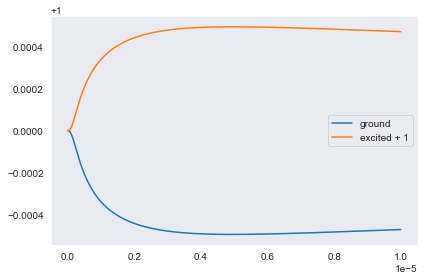

In [212]:
ground_state_tot = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(8)
        ]
    )
    for t in range(len(times))
]
tot_excited_exp_even = [
    sum(
        [
            res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
            for i in range(8, 16)
        ]
    )
    + 1
    for t in range(len(times))
]
fig, ax = plt.subplots()
ax.plot(times, ground_state_tot, label="ground")
ax.plot(times, tot_excited_exp_even, label="excited + 1")
ax.legend()
plt.tight_layout()


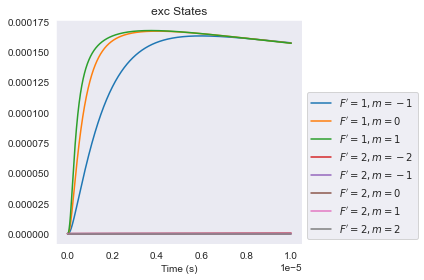

In [213]:
exc_expeven = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8, 16)
]
plt.figure()
for k, e in enumerate(exc_expeven):
    plt.plot(times, np.real(e))
plt.legend(
    [index_to_F_mF_string(i) for i in range(8, 16)],
    loc="best",
    bbox_to_anchor=(1.0, 0.7),
)
plt.title("exc States")
plt.xlabel("Time (s)")

plt.tight_layout()


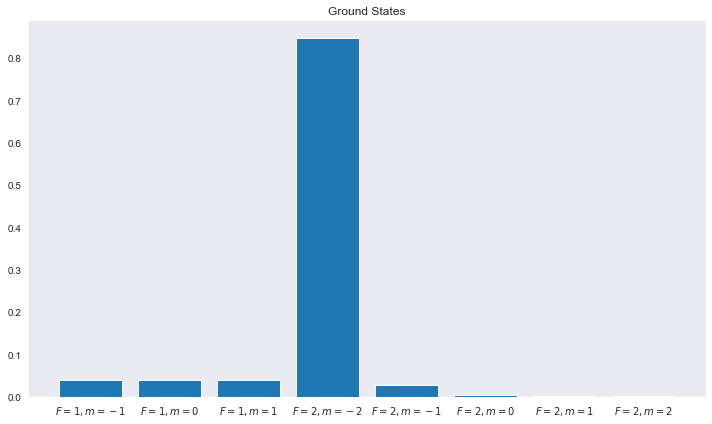

In [214]:
plt.figure(figsize=(10, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8)],
    [np.real(e)[-1] for e in ground_exp_even],
)
plt.title("Ground States")
plt.tight_layout()


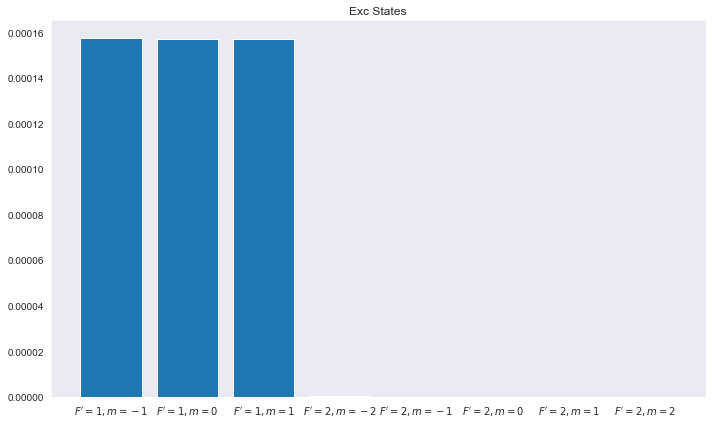

In [215]:
plt.figure(figsize=(10, 6))
plt.bar(
    [index_to_F_mF_string(i) for i in range(8, 16)],
    [np.real(e)[-1] for e in exc_expeven],
)
plt.title("Exc States")
plt.tight_layout()


# MW Transition

## Init

In [216]:
A = 3.417341305452145e09  # Hz
MU_BOHR = 1.399624604e6  # Hz / G

# uncoupled basis
H_hfs = A * (
    tensor(spin_Jz(3 / 2), spin_Jz(1 / 2))  # I * J (S_1/2, where L=0)
    + tensor(spin_Jy(3 / 2), spin_Jy(1 / 2))
    + tensor(spin_Jx(3 / 2), spin_Jx(1 / 2))
)


def H_B(bx=0, by=0, bz=0):  # in G
    return (
        2.0023193043622
        * (
            tensor(qeye(4), spin_Jx(1 / 2)) * bx
            + tensor(qeye(4), spin_Jy(1 / 2)) * by
            + tensor(qeye(4), spin_Jz(1 / 2)) * bz
        )
        - 0.000995
        * (
            tensor(spin_Jx(3 / 2), qeye(2)) * bx
            + tensor(spin_Jy(3 / 2), qeye(2)) * by
            + tensor(spin_Jz(3 / 2), qeye(2)) * bz
        )
    ) * MU_BOHR


energs, F_states = (H_hfs + H_B(bz=0.1)).eigenstates()
F_states_reordered = [
    F_states[2],
    F_states[1],
    F_states[0],
]  # to have same basis in the same order: |F=1, m=-1>, |F=1, m=0>, ...
for k in range(3, 3 + 5):
    F_states_reordered.append(F_states[k])

# RWA
def h_mw_a(det_mw):
    return sum([(ens[f] - det_mw) * basis(8, f).proj() for f in range(3, 8)]) + sum(
        [ens[f1] * basis(8, f1).proj() for f1 in range(3)]
    )


def B_loop(power_mw, radius=3e-3, distance=0.02):  # in Gauss
    return (
        constants.mu_0
        * radius**2
        * (power_mw / 50) ** (1 / 2)
        / (2 * (distance**2 + radius**2) ** (3 / 2))
        * 1e4
    )


Bmw = B_loop(1e-1)
# transition_coeffs = tensor(qeye(4), spin_Jx(1 / 2)).transform(F_states_reordered)
# det_mw = 0
# rabi_mw = 1e6
H_0 = H_hfs + H_B(bz=0.1)
E_0 = H_0.eigenenergies()[5] - H_0.eigenenergies()[1]  # clock transition
ens = H_0.eigenenergies() - H_0.eigenenergies()[1]
ens = [en if k < 3 else en - E_0 for k, en in enumerate(ens)]
tmp = ens[0]
ens[0] = ens[2]
ens[2] = tmp


In [217]:
ens


[70237.18127632141,
 0.0,
 -70235.74342823029,
 -139918.74989700317,
 -69958.65598106384,
 0.0,
 69957.21813106537,
 139912.998503685]

In [218]:
139912.998503685 - (-70237.18127632141)


210150.1797800064

In [219]:
3 * 70235.74342823029


210707.23028469086

### MW Hamiltonian I, J basis and F basis

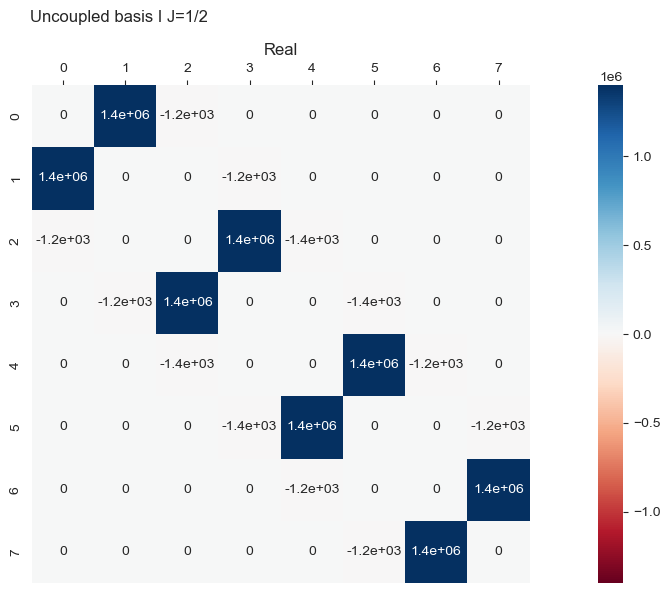

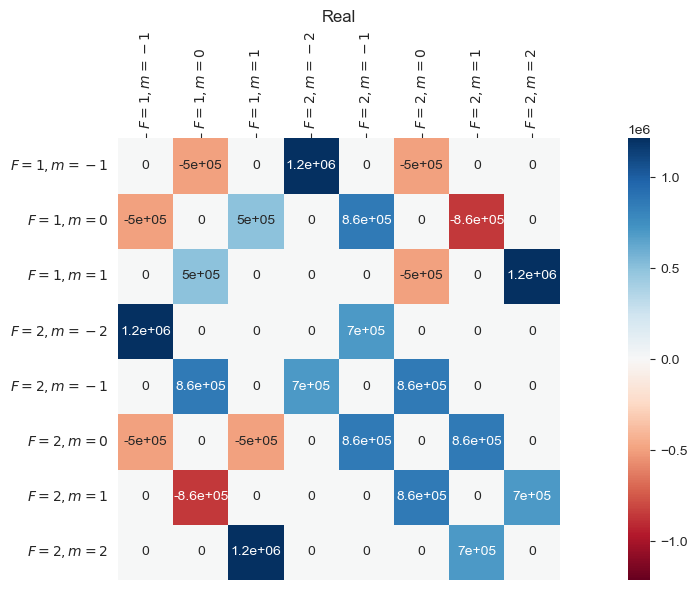

In [220]:
hbt = H_B(bx=1, by=0.0, bz=0.0)
fig, _ = matrixplot(hbt, annot=True)
fig.set_size_inches(14, 6)
fig.suptitle("Uncoupled basis I J=1/2")
plt.tight_layout()
fig, _ = maplot(hbt.transform(F_states_reordered), annot=True)
fig.set_size_inches(14, 6)
plt.tight_layout()


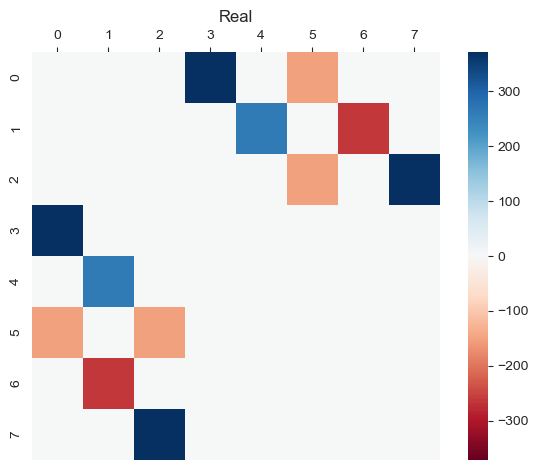

In [221]:
# remove fast rotating terms in the MW hamiltonian (Zeeman-level transitions)
hmw_arr = H_B(bx=Bmw).transform(F_states_reordered).full()
hmw_arr_rwa = hmw_arr.copy()
for n in range(8):
    for m in range(8):
        if abs(n - m) < 2:
            hmw_arr_rwa[n, m] = 0.0
matrixplot(hmw_arr_rwa)
H_mw = Qobj(hmw_arr_rwa) + h_mw_a(139912.998503685 - (-70237.18127632141))
H_mw_fl = Qobj(tensor(Qobj([[1, 0], [0, 0]]), H_mw).full())


## No Light

In [222]:
L = liouvillian(
    H_mw_fl,
)


### Time Evo

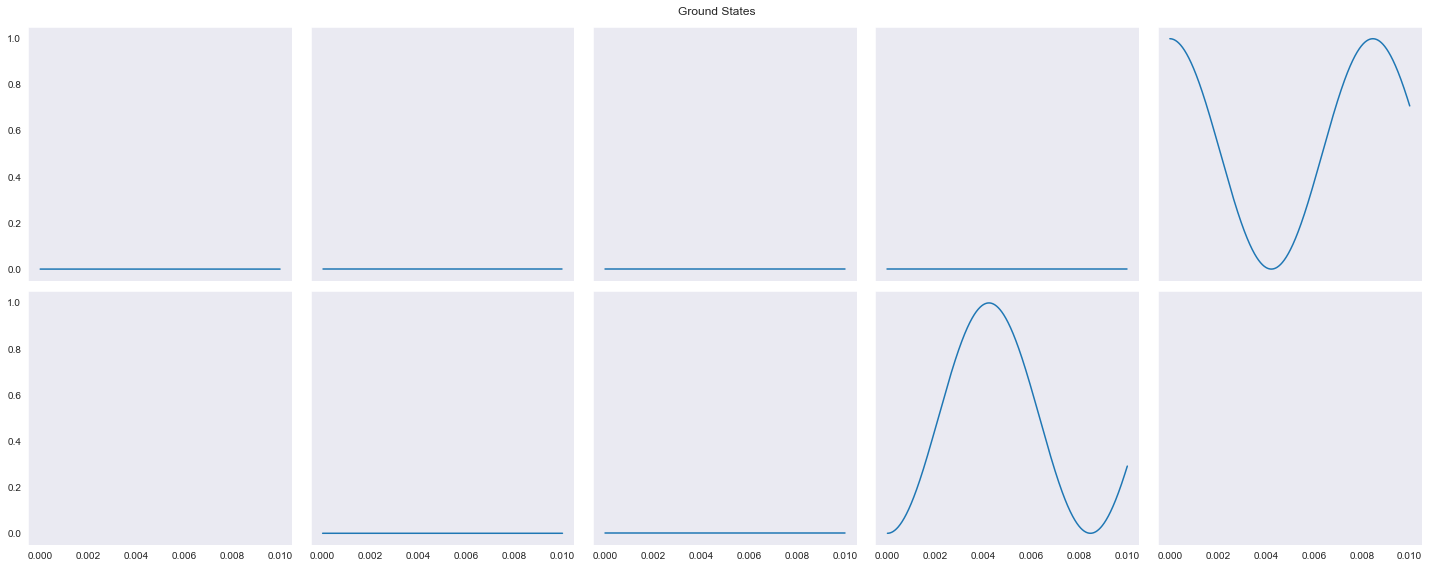

In [223]:
rho_zero = basis(16, 7).proj()
times = np.linspace(0, 1e-2, 1001)
opts = Options(nsteps=1 * 10**3)
res = mesolve(
    L,
    rho_zero,
    times,
    options=opts,
)

ground_exp_val = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 8), sharex="all", sharey="all")
for i, e in enumerate(ground_exp_val[:3]):
    axs[1, 1 + i].plot(times, np.real(e))
for i, e in enumerate(ground_exp_val[3:8]):
    axs[0, i].plot(times, np.real(e))
# fig.delaxes(axs[1][0])
# fig.delaxes(axs[1][-1])
# ax.legend(
#     [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
# )
fig.suptitle("Ground States")
# ax.set_xlabel("Time (s)")

plt.tight_layout()


### Time Evolution as a Function of Frequency: $\text{min}\langle F=2, m_F=2 \rangle (f)$  

In [224]:
frequencies = np.linspace(
    3 * 70235.74342823029 - 25000, 3 * 70235.74342823029 + 25000, 201
)
rho_zero = basis(16, 7).proj()
expectation_values = []
times = np.linspace(0, 1e-2, 1001)
opts = Options(nsteps=1 * 10**5)
for freq in frequencies:
    H_mw = Qobj(H_B(bx=Bmw).transform(F_states_reordered).full()) + h_mw_a(freq)
    H_mw_fl = Qobj(tensor(Qobj([[1, 0], [0, 0]]), H_mw).full())
    L = liouvillian(
        0 * hamil + H_mw_fl,
        # c_ops=intra_F1 + intra_F2,
    )
    res = mesolve(L, rho_zero, times, options=opts, e_ops=rho_zero)
    expectation_values.append(res.expect[0].min())


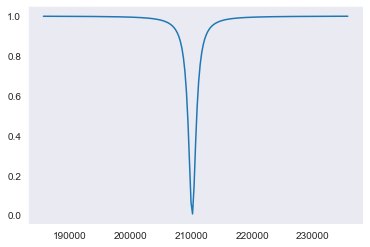

In [225]:
plt.plot(frequencies, expectation_values)


## With Light, rad decay

(<Figure size 600x480 with 2 Axes>, <AxesSubplot:title={'center':'Real'}>)

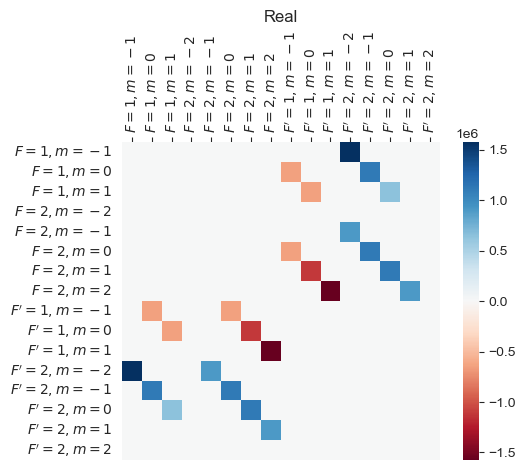

In [226]:
laser_intens = 0.1 * off_resonant_saturation_intensity_D1_pi_pol
maplot(H_AF(q=1, intens=laser_intens))


(<Figure size 600x480 with 2 Axes>, <AxesSubplot:title={'center':'Real'}>)

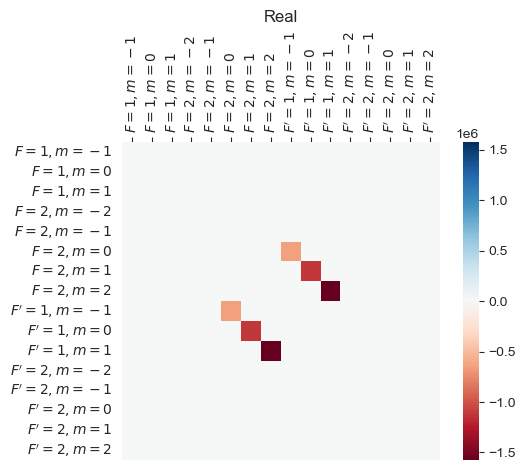

In [227]:
h_af_fp1_only = sum(
    [
        basis(16, f).proj() * H_AF(q=1, intens=laser_intens) * basis(16, i).proj()
        for i in range(8, 11)
        for f in range(3, 8)
    ]
)
h_af_fp1_only += h_af_fp1_only.dag()
maplot(h_af_fp1_only)


In [228]:
hamil = h_af_fp1_only + Ha(-509.06e6 - 2.563005979089109e9)  # resonant to F=2 -> F'=1
L = liouvillian(
    hamil + H_mw_fl,
    # c_ops=intra_F1 + intra_F2,
    c_ops=natural_decay_ops,
)
inds = np.argsort(abs(L.eigenstates()[0]))
L_eigs_sorted = L.eigenstates()[0][inds]
L_states_sorted = L.eigenstates()[1][inds]


<AxesSubplot:>

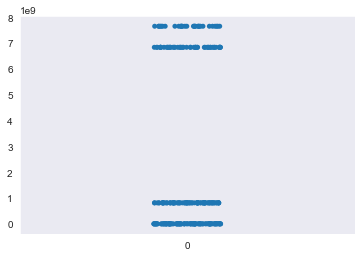

In [229]:
sns.stripplot(data=abs(L_eigs_sorted))


In [230]:
L_eigs_sorted[:10]


array([ 1.10825080e-07-2.75603964e-07j, -1.00464099e-06-1.23669605e-09j,
        9.94206958e-07-4.79980591e-07j,  2.38146493e-07-1.62599831e-06j,
       -6.10778480e-01+3.75139823e-07j, -4.19915408e-01+6.99612395e+04j,
       -4.19915603e-01-6.99612395e+04j, -2.45392223e-07-7.02360717e+04j,
       -8.41651581e-07+7.02360717e+04j, -3.20664691e-07-7.02375096e+04j])

(<Figure size 1680x672 with 4 Axes>,
 [<AxesSubplot:title={'center':'Real'}>,
  <AxesSubplot:title={'center':'Imag'}>])

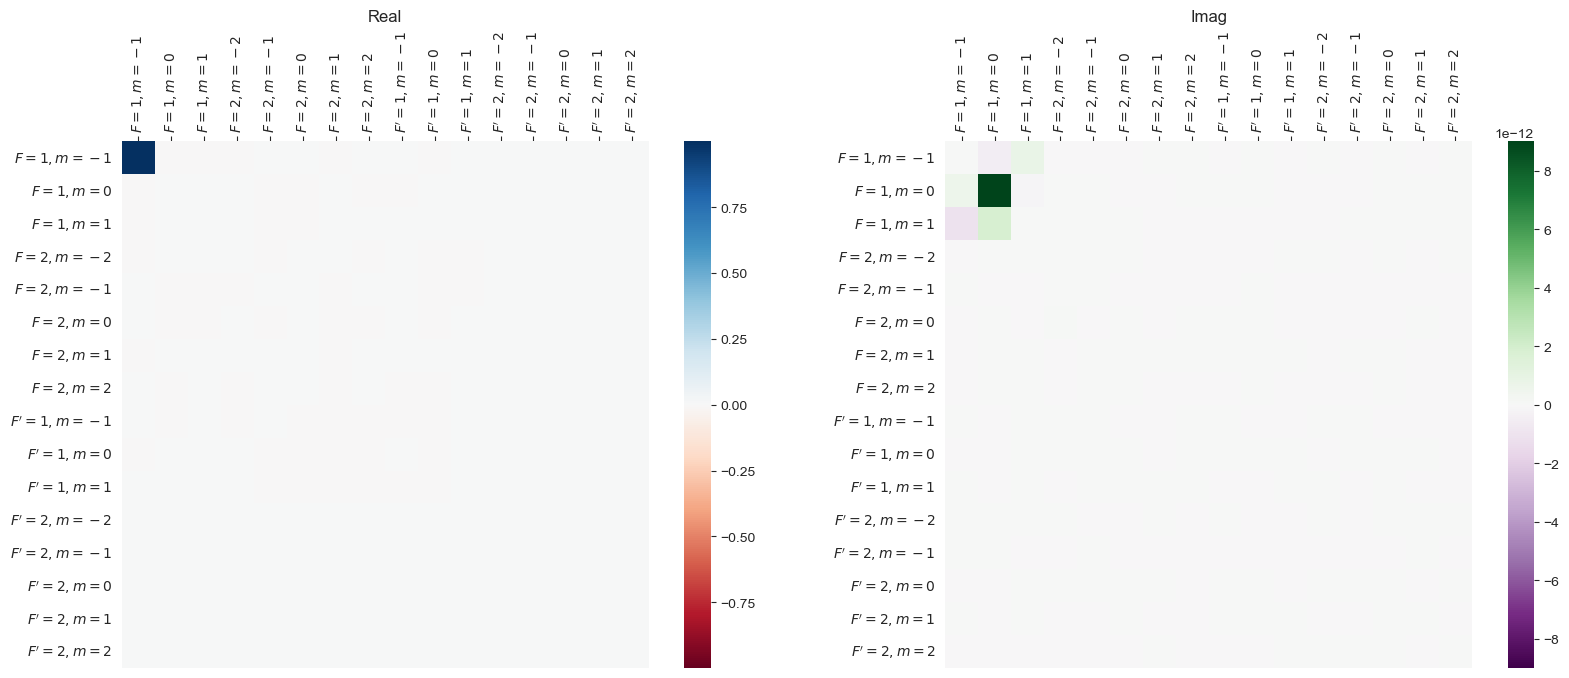

In [231]:
maplot(vector_to_operator(L_states_sorted[0]))


(<Figure size 1680x672 with 4 Axes>,
 [<AxesSubplot:title={'center':'Real'}>,
  <AxesSubplot:title={'center':'Imag'}>])

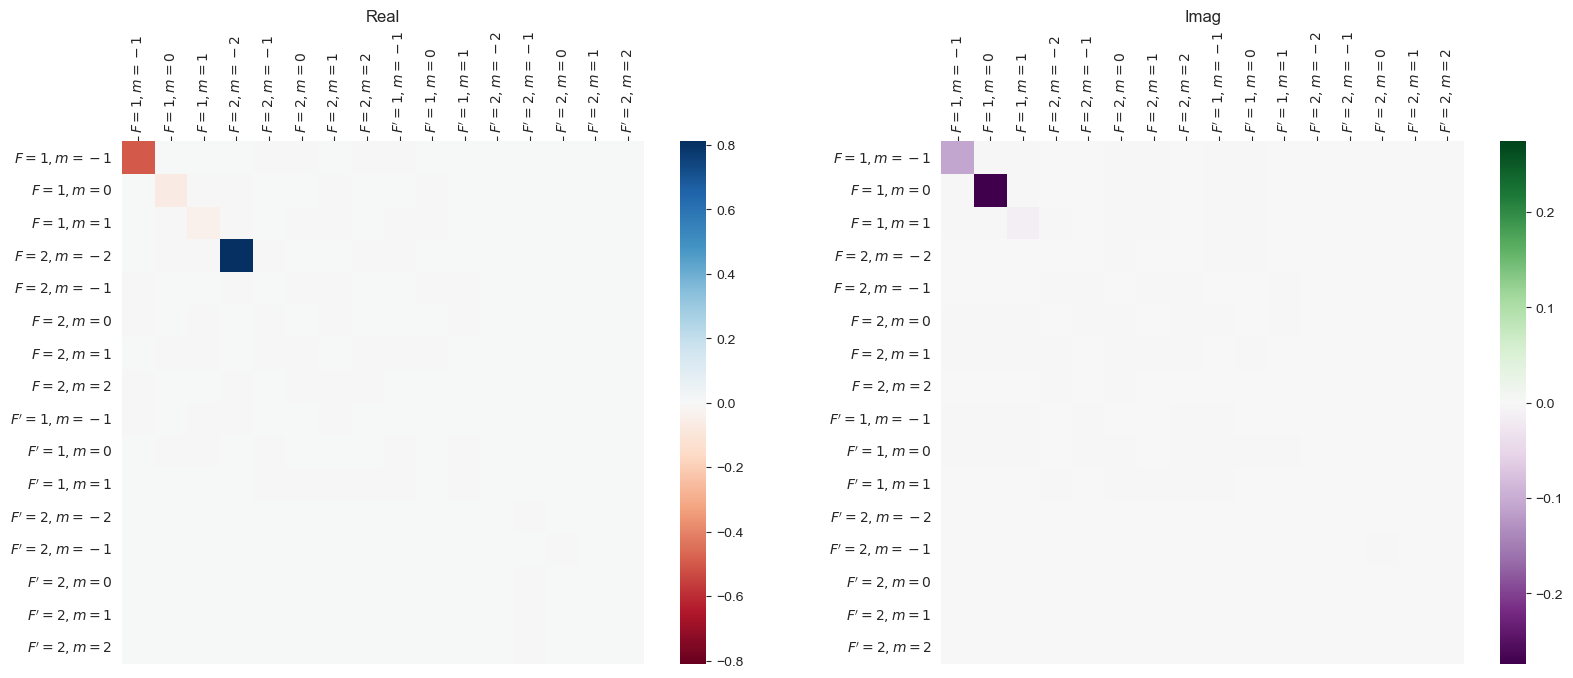

In [232]:
maplot(vector_to_operator(L_states_sorted[1]))


(<Figure size 1680x672 with 4 Axes>,
 [<AxesSubplot:title={'center':'Real'}>,
  <AxesSubplot:title={'center':'Imag'}>])

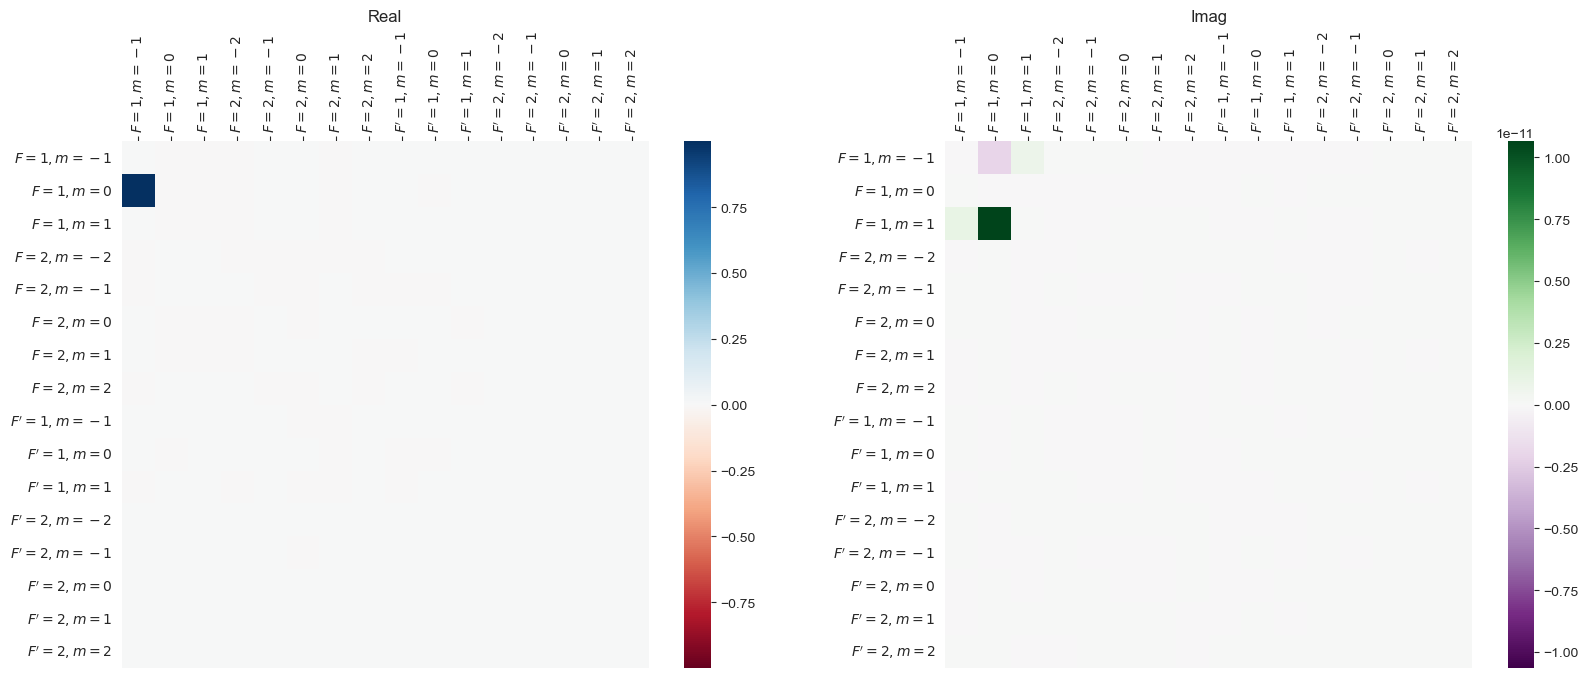

In [233]:
maplot(vector_to_operator(L_states_sorted[10]))


### Time Evo

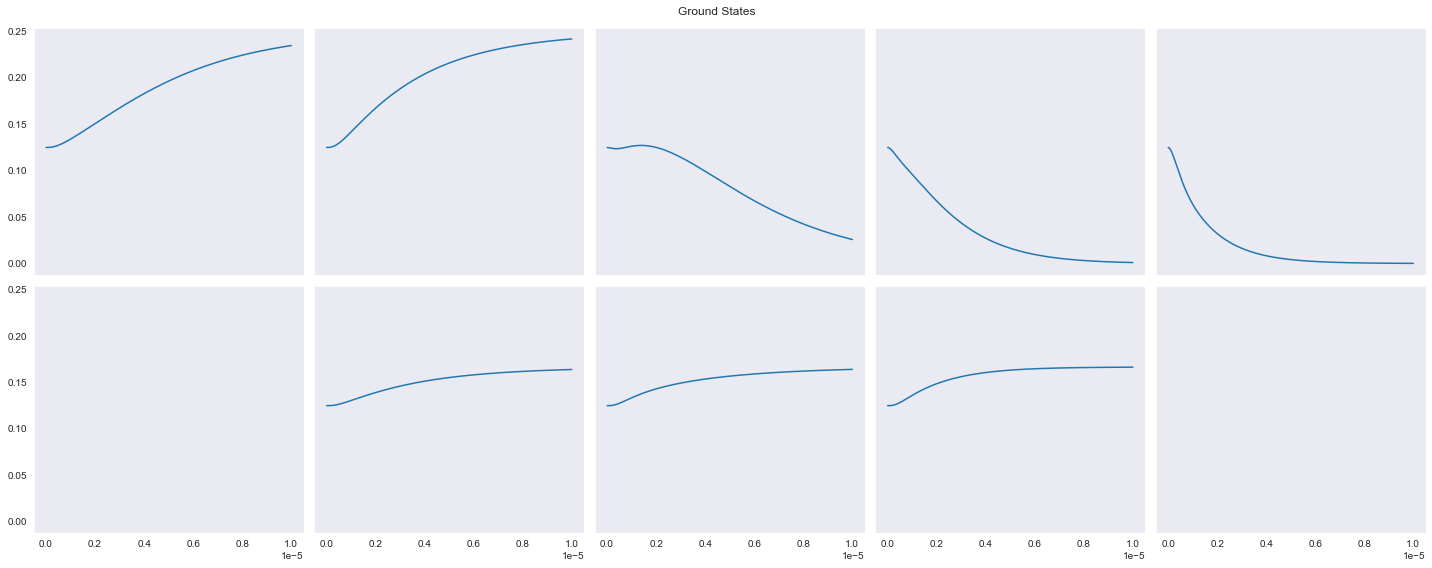

In [234]:
rho_zero = sum([basis(16, i).proj() for i in range(8)]).unit()  # equally distrib

# rho_zero = basis(16, 7).proj()

times = np.linspace(0, 1e-5, 1001)
opts = Options(nsteps=1 * 10**4)
res = mesolve(
    L,
    rho_zero,
    times,
    options=opts,
)

# maplot(res.states[-1])

ground_exp_val = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 8), sharex="all", sharey="all")
for i, e in enumerate(ground_exp_val[:3]):
    axs[1, 1 + i].plot(times, np.real(e))
for i, e in enumerate(ground_exp_val[3:8]):
    axs[0, i].plot(times, np.real(e))
# fig.delaxes(axs[1][0])
# fig.delaxes(axs[1][-1])
# ax.legend(
#     [index_to_F_mF_string(i) for i in range(8)], loc="best", bbox_to_anchor=(1.0, 0.7)
# )
fig.suptitle("Ground States")
# ax.set_xlabel("Time (s)")

plt.tight_layout()


c:\Users\m\anaconda3\envs\masterarbeit_python39\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning:

Casting complex values to real discards the imaginary part



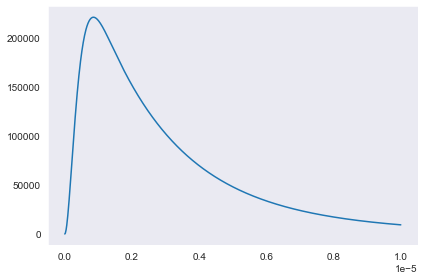

In [235]:
absorbed_mw = [
    (sum([basis(16, k).proj() for k in range(8, 16)]) * rho_t).tr() * gamma_natural
    for rho_t in res.states
]
fig, ax = plt.subplots()
ax.plot(times, absorbed_mw)
plt.tight_layout()


### Time Evolution as a Function of Frequency

In [236]:
frequencies = np.linspace(
    3 * 70235.74342823029 - 25000, 3 * 70235.74342823029 + 25000, 201
)
rho_zero = basis(16, 7).proj()
expectation_values = []
times = np.linspace(0, 1e-4, 1001)
opts = Options(nsteps=1 * 10**5)
for freq in frequencies:
    H_mw = Qobj(H_B(bx=Bmw).transform(F_states_reordered).full()) + h_mw_a(freq)
    H_mw_fl = Qobj(tensor(Qobj([[1, 0], [0, 0]]), H_mw).full())
    L = liouvillian(
        hamil + H_mw_fl,
        # c_ops=intra_F1 + intra_F2,
        c_ops=natural_decay_ops,
    )
    res = mesolve(L, rho_zero, times, options=opts, e_ops=rho_zero)
    expectation_values.append(res.expect[0].min())


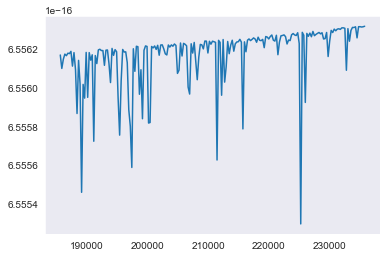

In [237]:
plt.plot(frequencies, expectation_values)


In [238]:
min(expectation_values)


6.555295304368279e-16

In [239]:
np.argmin(expectation_values)


158

### without mw

In [240]:
L = liouvillian(
    hamil,
    # c_ops=intra_F1 + intra_F2,
    c_ops=natural_decay_ops,
)


In [241]:
rho_zero = sum([basis(16, i).proj() for i in range(8)]).unit()  # equally distrib
# rho_zero = basis(16, 7).proj()


In [242]:
times = np.linspace(0, 1e-5, 1001)
opts = Options(nsteps=1 * 10**4)
res = mesolve(
    L,
    rho_zero,
    times,
    options=opts,
)


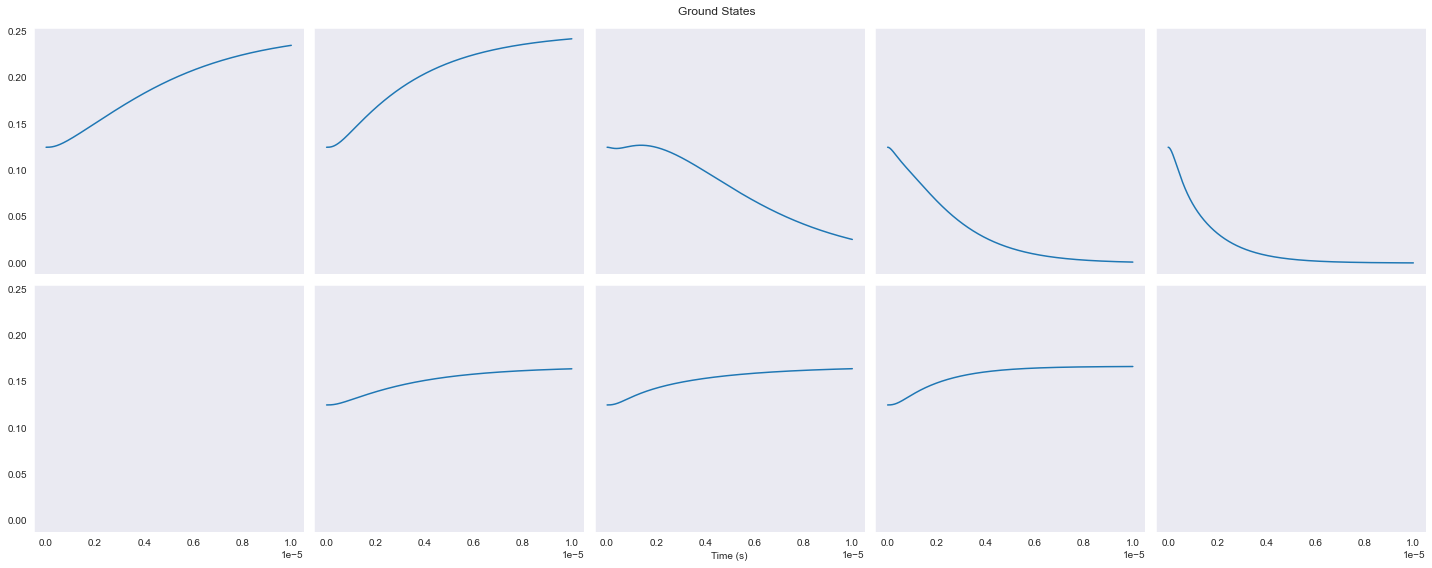

In [243]:
ground_exp_val = [
    [
        res.states[t].matrix_element(basis(16, i).dag(), basis(16, i))
        for t in range(len(times))
    ]
    for i in range(8)
]
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 8), sharex="all", sharey="all")
for i, e in enumerate(ground_exp_val[:3]):
    axs[1, 1 + i].plot(times, np.real(e))
for i, e in enumerate(ground_exp_val[3:8]):
    axs[0, i].plot(times, np.real(e))
fig.suptitle("Ground States")
axs[1, 2].set_xlabel("Time (s)")
plt.tight_layout()


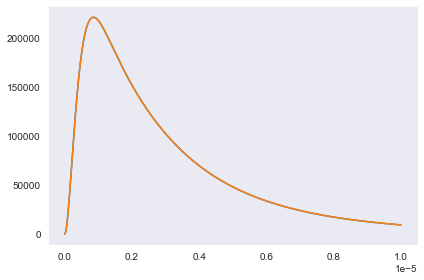

In [244]:
absorbed_no_mw = [
    (sum([basis(16, k).proj() for k in range(8, 16)]) * rho_t).tr() * gamma_natural
    for rho_t in res.states
]
fig, ax = plt.subplots()
ax.plot(times, absorbed_no_mw, label="no MW")
ax.plot(times, absorbed_mw, label="MW")
plt.tight_layout()


In [245]:
1


1